In [ ]:
import copy
from google.colab import drive
import matplotlib
matplotlib.rcParams['figure.figsize'] = [4, 3]
matplotlib.rcParams['font.size'] = 8
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import manual_seed, nn, norm, optim, tensor
from torch.autograd import grad, Variable
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader

In [ ]:
drive.mount('/content/drive')
!ls "/content/drive/My Drive/CMAP data"

Mounted at /content/drive
chicago.dbf			directions_walking_old2.json
chicago.prj			gps_place.csv
chicago.shp			household.csv
chicago.shx			location.csv
directions_bicycling.json	person.csv
directions_bicycling_old2.json	place.csv
directions_driving.json		X_normalized.csv
directions_driving_old2.json	X_normalized_old.csv
directions_transit.json		X_unnormalized.csv
directions_transit_old2.json	X_unnormalized_old.csv
directions_walking.json		y.csv


# Datasets

## Data import
We randomly sample 2000 OD pairs from the dataset, and use the first 90% of the data for training and the last 10% for testing.

In [ ]:
X0 = pd.read_csv('/content/drive/My Drive/CMAP data/X_normalized.csv', index_col=0).sample(2000, random_state=0)
y0 = pd.read_csv('/content/drive/My Drive/CMAP data/y.csv', index_col=0).sample(2000, random_state=0)['mode_imputed']

In [ ]:
X0 = X0[['age', 'hhveh', 'hhinc', 'dist_auto', 'time_auto', 'cost_auto', 'dist_walk', 'time_walk',
         'dist_train', 'time_train', 'cost_train', 'dist_bike', 'time_bike']]  # Adjust column order
X0

age     hhveh     hhinc  dist_auto  time_auto  cost_auto  \
14248 -0.801326 -1.543605 -0.211011  -0.479532  -0.312851  -0.369635   
25673  0.837597  2.379070  0.988139  -0.454218  -0.502577  -0.543878   
30428  0.390618 -0.562936  0.988139   0.868557   0.965321   0.230311   
759    0.241625  1.398401  0.988139  -0.023913   0.196846   0.969480   
14551 -1.173808 -0.562936 -2.609311  -0.463836  -0.386348   0.153668   
...         ...       ...       ...        ...        ...        ...   
21274 -1.620787 -1.543605 -2.609311  -0.680589  -0.916555  -0.913606   
15697  0.912094  0.417733  0.988139  -0.697158  -0.750759  -0.583492   
31429 -0.950319 -0.562936 -0.211011  -0.651169  -0.493689  -1.223626   
25824  1.284576  1.398401  0.588423   0.685799   0.541771   0.705389   
16195 -0.279850  0.417733  0.588423  -0.644719  -0.714523  -0.383127   

       dist_walk  time_walk  dist_train  time_train  cost_train  dist_bike  \
14248  -0.450538  -0.446574   -0.470508   -0.389627   -0.459100  -0.460205   
25673  -0.381647  -0.386610   -0.593434   -0.400554   -0.847245  -0.362990   
30428   0.843521   0.852349    0.708043    0.346350    0.095392   0.814521   
759    -0.068037  -0.068318   -0.039502   -0.335477    1.703421  -0.126738   
14551  -0.430610  -0.429983   -0.383340   -0.221388   -0.680897  -0.437372   
...          ...        ...         ...         ...         ...        ...   
21274  -0.741172  -0.739747   -0.703221   -0.658809   -0.847245  -0.742657   
15697  -0.724565  -0.722227   -0.675861   -0.628245   -0.847245  -0.655832   
31429  -0.697137  -0.694468   -0.650948   -0.635818   -0.015506  -0.674205   
25824   0.799157   0.785177    0.515747    0.209216    1.537073   0.701954   
16195  -0.599943  -0.596435   -0.621597   -0.619752   -0.902694  -0.658983   

       time_bike  
14248  -0.435978  
25673  -0.394879  
30428   0.820970  
759    -0.114687  
14551  -0.428476  
...          ...  
21274  -0.733457  
15697  -0.640658  
31429  -0.634134  
25824   0.675574  
16195  -0.652808  

[2000 rows x 13 columns]

In [ ]:
X_train, X_test, y_train, y_test = X0[:1800], X0[1800:], y0[:1800], y0[1800:]

## Data processing
1. Find a variable to visualize,
2. Build a dataframe with mean values, except for the above variable,
3. Build a dataframe with the same size for model regularity calculation, and
4. Load the data for training and testing.

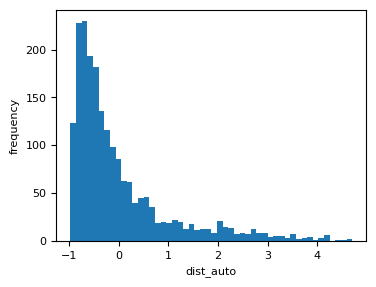

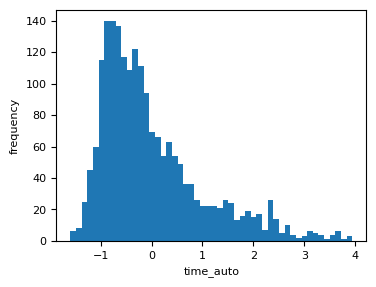

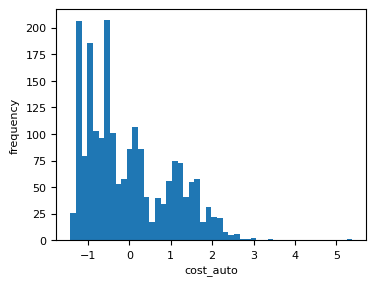

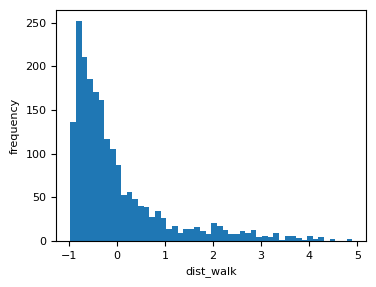

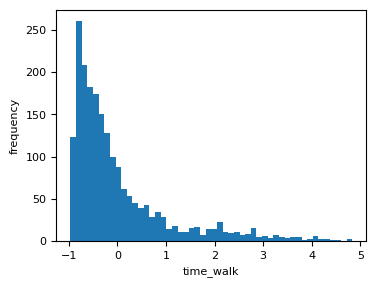

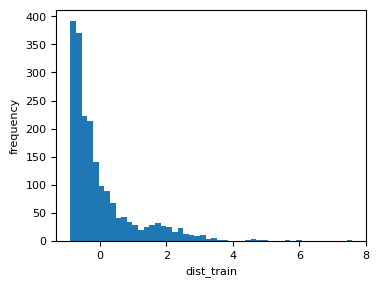

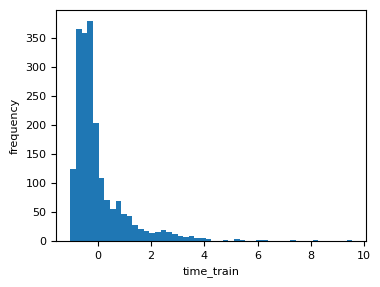

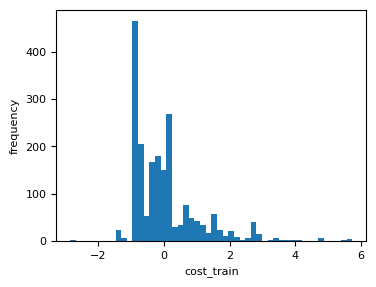

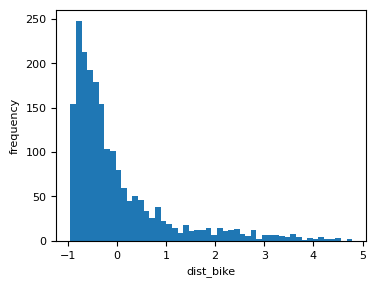

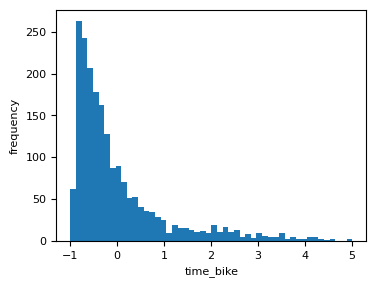

In [ ]:
for i in ['dist_auto', 'time_auto', 'cost_auto', 'dist_walk', 'time_walk',
          'dist_train', 'time_train', 'cost_train', 'dist_bike', 'time_bike']:
    plt.hist(X0[i], bins=50)
    plt.xlabel(i)
    plt.ylabel('frequency')
    plt.show()

In [ ]:
# The variable to visualize
var = 'time_auto'
# The corresponding mode
flag = 0
# The inputs to consider in regularization
if flag == 0:  # auto
    th = [3, 6]
elif flag == 1:  # walk
    th = [6, 8]
elif flag == 2:  # train
    th = [8, 11]
else:  # bike
    th = [11, 13]

In [ ]:
X_train[var].describe()

count    1800.000000
mean       -0.002550
std         1.017214
min        -1.593758
25%        -0.739221
50%        -0.290118
75%         0.452805
max         3.944874
Name: time_auto, dtype: float64

In [ ]:
lower, upper = X_train[var].min(), X_train[var].max()
X_plot = pd.DataFrame(np.zeros((51, 13)), columns=X_train.columns)
X_plot[var] = np.linspace(lower, upper, 51)
y_plot = pd.Series(np.ones(51))

In [ ]:
X_regu = X0.copy()
X_regu = X_regu.loc[X_regu.index.repeat(2)]
num_var = X_regu.columns.get_loc(var)
X_regu.iloc[range(1, len(X_regu), 2), num_var] = X_regu.iloc[range(1, len(X_regu), 2), num_var] + (upper-lower)/50
y_regu = pd.Series(np.ones(len(X_regu)))

In [ ]:
class Load_Data(Dataset):
    'Function to load the training, test, and plotting sets'
    def __init__(self, x_set, y_set):
        self.X = Variable(tensor(x_set.values).float(), requires_grad=True)
        self.y = tensor(y_set.values)
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def __len__(self):
        return len(self.X)

train_loader = DataLoader(Load_Data(X_train, y_train), batch_size=200, shuffle=True)
test_loader = DataLoader(Load_Data(X_test, y_test), batch_size=200)
plot_loader = DataLoader(Load_Data(X_plot, y_plot))
regu_loader = DataLoader(Load_Data(X_regu, y_regu))

# Deep neural network

## Structure
Here we apply a simple DNN with 3 hidden layers $\times$ 100 neurons. In order to improve the model regularity, we include 3 types of gradient regularizers in the loss function during training:
- gradient of mode utilities w.r.t. inputs,
- gradient of mode probabilities w.r.t. inputs, and
- gradient of the cross-entropy loss w.r.t. inputs.

Note that the above inputs are associated with the specific mode, i.e., to visualize `time_auto`, only `dist_auto`, `time_auto`, and `cost_auto` are considered.

Then, each of the above regularizer is added to the loss function in terms of
- "soft" sum: simply summing up all elements,
- "hard" sum: summing up after constraining element signs, and
- norm: finding the Frobenius norm of a matrix or vector.

Note that using sums can hopefully improve both strong and weak regularities, while using norms may improve the weak regularity.

In [ ]:
class FeedForward_DNN(nn.Module):
    'Class for the feedforward DNN'
    def __init__(self):
        super(FeedForward_DNN, self).__init__()
        # 3 hidden layers * 100 neurons
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(13, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 4)
        )
    def forward(self, x):
        return self.linear_relu_stack(x)

In [ ]:
def cal_loss(model, X, pred, y, reg, alpha, beta, criterion):
    'Function to regularize the loss function'
    'alpha: weight of the regularizer -> weight of the loss is (1-alpha)'
    'beta: indicating how the gradient is included, e.g., [1, 0, 0] -> finding the "soft" sum'
    loss = criterion(pred, y)
    regu = 0
    # Utility gradient regularization
    if reg == 'util':
        util = model(X)[:, flag]
        for i in range(len(X)):
            g = grad(util[i], X, create_graph=True)[0]
            regu += beta[0]*sum(g[i, th[0]:th[1]]) - beta[1]*sum(abs(g[i, th[0]:th[1]])) + beta[2]*norm(g[i, th[0]:th[1]])
    # Probability gradient regularization
    elif reg == 'prob':
        prob = softmax(model(X), dim=1)[:, flag]
        for i in range(len(X)):
            g = grad(prob[i], X, create_graph=True)[0]
            regu += beta[0]*sum(g[i, th[0]:th[1]]) - beta[1]*sum(abs(g[i, th[0]:th[1]])) + beta[2]*norm(g[i, th[0]:th[1]])
    # Loss gradient regularization
    elif reg == 'loss':
        g = grad(loss, X, create_graph=True)[0]
        regu = -beta[0]*g[:, th[0]:th[1]].sum() + beta[1]*abs(g[:, th[0]:th[1]]).sum() + beta[2]*norm(g[:, th[0]:th[1]])
    # No regularization
    else:
        pass
    return (1-alpha) * loss + alpha * regu

def train_loop(model, dataloader, reg, alpha, beta, optimizer, criterion):
    'Function for each training loop'
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = cal_loss(model, X, pred, y, reg, alpha, beta, criterion)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

def test_loop(model, dataloader, criterion):
    'Function for each test loop'
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    for X, y in dataloader:
        pred = model(X)
        test_loss += criterion(pred, y).item()
        correct += (pred.argmax(1) == y).float().sum()
    test_loss /= num_batches
    test_accu = correct / size
    list_plot, list_grad, list_regu = [], [], []
    for X, _ in plot_loader:
        prob_plot = softmax(model(X), dim=1)[:, flag]
        list_plot.append(prob_plot.detach().numpy()[0])
        list_grad.append(grad(prob_plot, X, create_graph=True)[0][:, num_var].detach().numpy()[0])
    for X, _ in regu_loader:
        prob_regu = softmax(model(X), dim=1)[:, flag]
        list_regu.append(prob_regu.detach().numpy()[0])
    return test_loss, list_plot, list_grad, list_regu, test_accu

## Training
We train each model 30 times to ensure its convergence and take the average of 5 models for visualization.

In [ ]:
def train_DNN(reg, alpha, beta):
    'Function to train the DNN'
    list_loss, list_plot, list_grad, list_regu, list_accu = [[] for i in range(5)]
    for i in range(5):
        manual_seed(i)
        model = FeedForward_DNN()
        num_epochs = 30
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters())
        for t in range(num_epochs):
            train_loop(model, train_loader, reg, alpha, beta, optimizer, criterion)
            loss, plot, grad, regu, accu = test_loop(model, test_loader, criterion)
        list_loss.append(loss)
        list_plot.append(plot)
        list_grad.append(grad)
        list_regu.append(regu)
        list_accu.append(accu)
        print(f'Model {i+1}: test_loss = {loss:.4f}, test_accuracy = {accu*100:.1f}%')
    return list_loss, list_plot, list_grad, list_regu, list_accu

# Results

In [ ]:
def calc_regu(list_regu):
    'Function to calculate strong and weak regularities'
    list_df = []
    for regu in list_regu:
        y_regu = pd.DataFrame(regu, columns=['prob'])
        df = X_regu[[var]].reset_index(drop=True).join(y_regu)
        df['diff_st'], df['diff_wk'] = np.nan, np.nan
        for i in range(0, len(df), 2):
            df.loc[i, 'diff_st'] = (df.loc[i, 'prob'] > df.loc[i+1, 'prob'] + 1e-3).astype(int)
            df.loc[i, 'diff_wk'] = (df.loc[i, 'prob'] > df.loc[i+1, 'prob'] - 1e-3).astype(int)
        list_df.append(df.iloc[:-1:2])
    df_total = pd.concat(list_df)
    regu_st = sum(df_total['diff_st']) / len(df_total)
    regu_wk = sum(df_total['diff_wk']) / len(df_total)
    # Plot histogram of regularities
    plt.hist(df_total[var], bins=50, color='gray')
    plt.hist(df_total[var], weights=df_total['diff_wk'], bins=50)
    plt.hist(df_total[var], weights=df_total['diff_st'], bins=50)
    plt.xlabel(f'{var} (normalized)')
    plt.ylabel('Frequency')
    plt.show()
    return regu_st, regu_wk

In [ ]:
def calc_plot(list_plot, list_grad, list_regu):
    'Function to plot probabilities & probability derivatives'
    regu_st, regu_wk = calc_regu(list_regu)
    print(f'Strong regularity = {regu_st:.4f}')
    print(f'Weak regularity = {regu_wk:.4f}')
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    # Plot probabilities
    for prob in list_plot:
        axes[0].plot(X_plot[var], prob, color='gray', alpha=.3)
    axes[0].plot(X_plot[var], np.mean(list_plot, axis=0), color='r')
    axes[0].set(xlabel=f'{var} (normalized)', ylabel='Probability')
    # Plot probability derivatives
    for prob in list_grad:
        axes[1].plot(X_plot[var], prob, color='gray', alpha=.3)
    axes[1].plot(X_plot[var], np.mean(list_grad, axis=0), color='r')
    axes[1].set(xlabel=f'{var} (normalized)', ylabel='Probability derivative')
    fig.tight_layout()
    plt.show()
    return regu_st, regu_wk

In [ ]:
def result(reg_method, alphas, beta):
    'Function to print and plot results'
    perf_loss, perf_accu, list_st, list_wk = [[] for i in range(4)]
    for alpha in alphas:
        print('Penalty =', alpha)
        list_loss, list_plot, list_grad, list_regu, list_accu = train_DNN(reg_method, alpha, beta)
        mean_loss = np.mean(list_loss)
        mean_accu = np.mean(list_accu)
        print(f'Mean loss = {mean_loss:.4f}')
        print(f'Mean accuracy = {mean_accu*100:.1f}%')
        perf_loss.append(mean_loss)
        perf_accu.append(mean_accu)
        regu_st, regu_wk = calc_plot(list_plot, list_grad, list_regu)
        list_st.append(regu_st)
        list_wk.append(regu_wk)
    if len(alphas) == 1:
        return
    print('Model comparison:')
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    # Plot test losses
    axes[0].plot(np.log(alphas), perf_loss, marker='.')
    axes[0].set(xlabel=r'$\log(\alpha)$', ylabel='Test loss')
    # Plot test accuracies
    axes[1].plot(np.log(alphas), perf_accu, marker='.')
    axes[1].set(xlabel=r'$\log(\alpha)$', ylabel='Test accuracy')
    # Plot regularities
    axes[2].plot(np.log(alphas), list_st, marker='.', label='Strong')
    axes[2].plot(np.log(alphas), list_wk, marker='.', label='Weak')
    axes[2].set(xlabel=r'$\log(\alpha)$', ylabel='Model regularity')
    axes[2].legend()
    fig.tight_layout()

## No regularization

Penalty = 0
Model 1: test_loss = 0.6871, test_accuracy = 76.0%
Model 2: test_loss = 0.6797, test_accuracy = 75.0%
Model 3: test_loss = 0.6988, test_accuracy = 73.5%
Model 4: test_loss = 0.6827, test_accuracy = 74.0%
Model 5: test_loss = 0.7055, test_accuracy = 76.0%
Mean loss = 0.6908
Mean accuracy = 74.9%


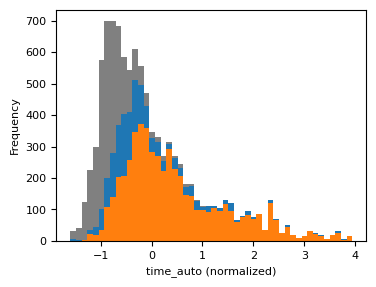

Strong regularity = 0.5402
Weak regularity = 0.7047


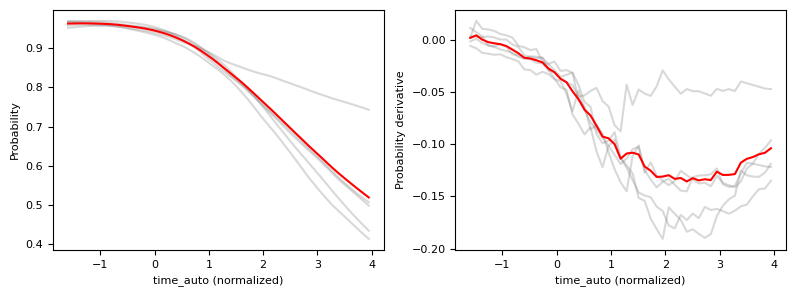

In [ ]:
result('none', [0], [0, 0, 0])

## Utility gradient regularization

Penalty = 0.9
Model 1: test_loss = 304.0854, test_accuracy = 60.0%
Model 2: test_loss = 309.0126, test_accuracy = 58.5%
Model 3: test_loss = 311.2010, test_accuracy = 56.0%
Model 4: test_loss = 242.1042, test_accuracy = 53.5%
Model 5: test_loss = 390.2846, test_accuracy = 61.5%
Mean loss = 311.3376
Mean accuracy = 57.9%


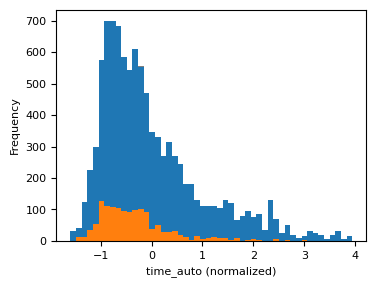

Strong regularity = 0.1345
Weak regularity = 0.9993


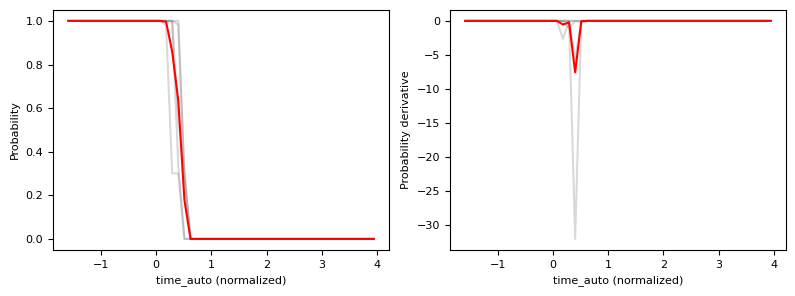

Penalty = 0.1
Model 1: test_loss = 282.7595, test_accuracy = 58.5%
Model 2: test_loss = 300.9686, test_accuracy = 56.5%
Model 3: test_loss = 278.4250, test_accuracy = 58.5%
Model 4: test_loss = 246.8541, test_accuracy = 53.5%
Model 5: test_loss = 385.0345, test_accuracy = 61.5%
Mean loss = 298.8083
Mean accuracy = 57.7%


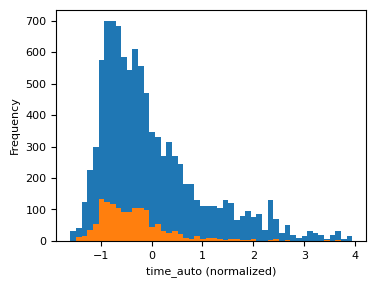

Strong regularity = 0.1408
Weak regularity = 1.0000


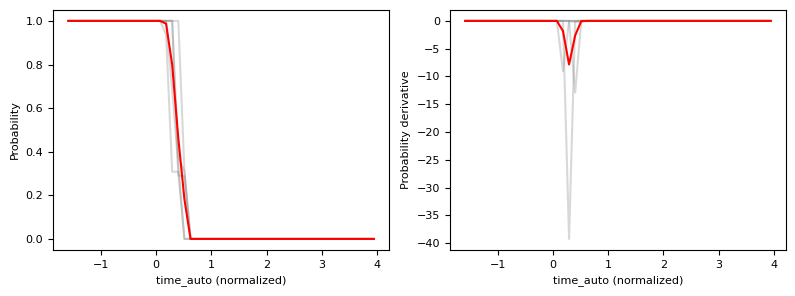

Penalty = 0.01
Model 1: test_loss = 240.9628, test_accuracy = 53.5%
Model 2: test_loss = 246.5218, test_accuracy = 40.5%
Model 3: test_loss = 225.4136, test_accuracy = 53.5%
Model 4: test_loss = 185.3146, test_accuracy = 40.5%
Model 5: test_loss = 247.7108, test_accuracy = 49.5%
Mean loss = 229.1847
Mean accuracy = 47.5%


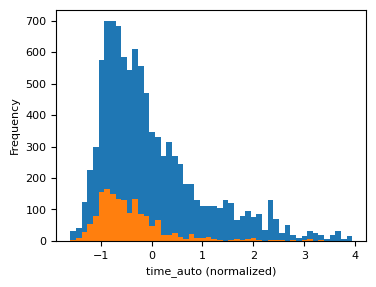

Strong regularity = 0.1592
Weak regularity = 1.0000


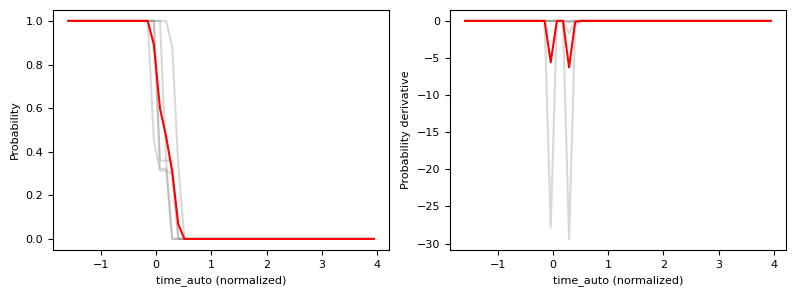

Penalty = 0.001
Model 1: test_loss = 20.8939, test_accuracy = 46.5%
Model 2: test_loss = 28.2526, test_accuracy = 68.0%
Model 3: test_loss = 22.9314, test_accuracy = 65.0%
Model 4: test_loss = 20.5457, test_accuracy = 73.5%
Model 5: test_loss = 29.9616, test_accuracy = 45.5%
Mean loss = 24.5170
Mean accuracy = 59.7%


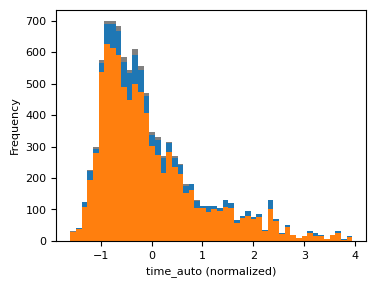

Strong regularity = 0.8647
Weak regularity = 0.9826


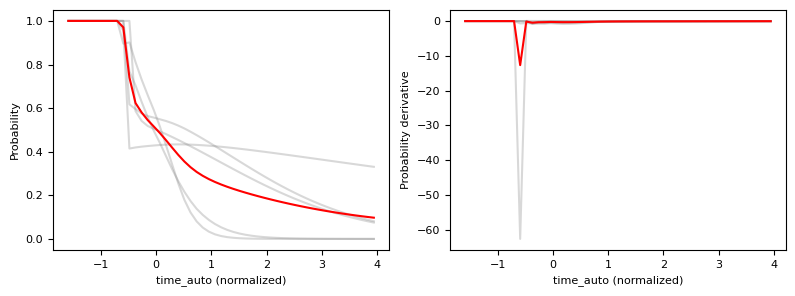

Penalty = 0.0001
Model 1: test_loss = 0.8037, test_accuracy = 75.0%
Model 2: test_loss = 0.8659, test_accuracy = 75.0%
Model 3: test_loss = 0.7938, test_accuracy = 73.0%
Model 4: test_loss = 1.1282, test_accuracy = 75.0%
Model 5: test_loss = 0.8358, test_accuracy = 75.0%
Mean loss = 0.8855
Mean accuracy = 74.6%


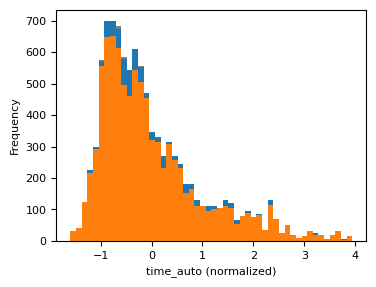

Strong regularity = 0.9213
Weak regularity = 0.9972


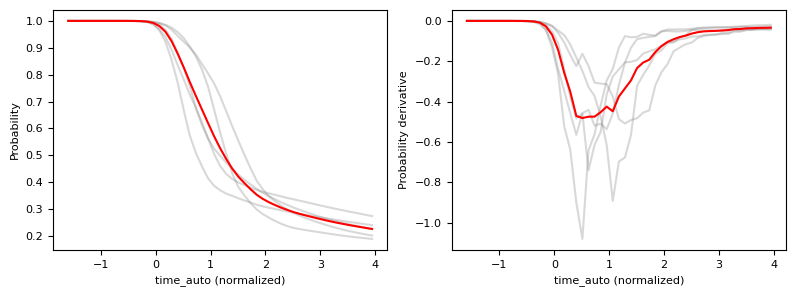

Penalty = 1e-05
Model 1: test_loss = 0.6883, test_accuracy = 75.5%
Model 2: test_loss = 0.6830, test_accuracy = 74.5%
Model 3: test_loss = 0.6971, test_accuracy = 74.0%
Model 4: test_loss = 0.6848, test_accuracy = 73.5%
Model 5: test_loss = 0.7054, test_accuracy = 75.5%
Mean loss = 0.6917
Mean accuracy = 74.6%


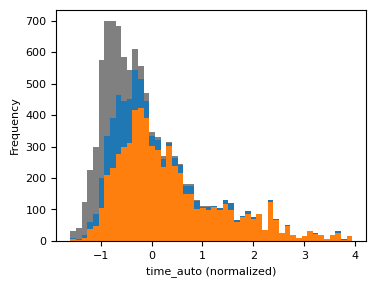

Strong regularity = 0.6221
Weak regularity = 0.7755


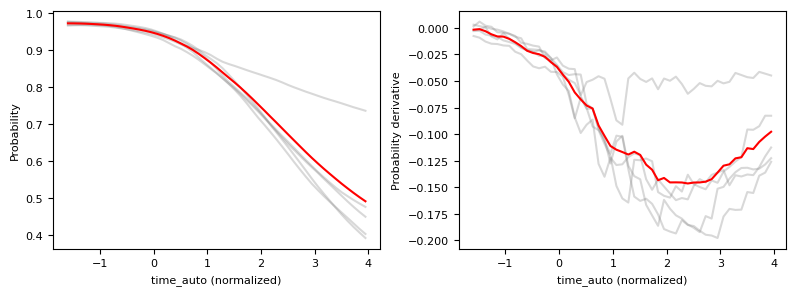

Model comparison:


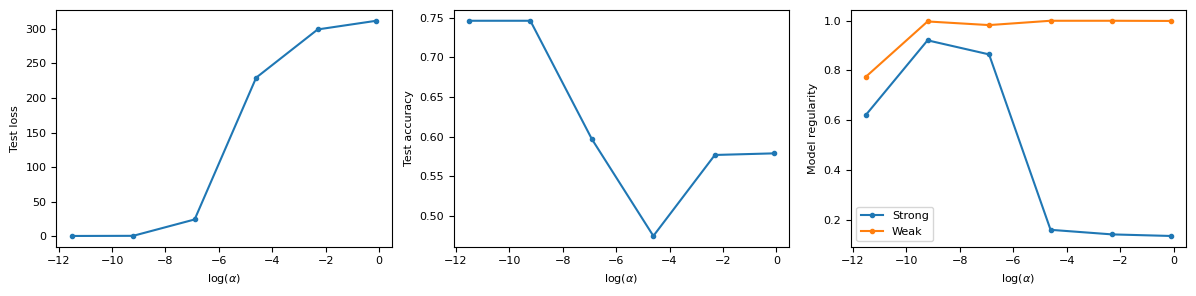

In [ ]:
# With "soft" sum
result('util', [.9, .1, 1e-2, 1e-3, 1e-4, 1e-5], [1, 0, 0])

Penalty = 0.9
Model 1: test_loss = 231.2825, test_accuracy = 54.5%
Model 2: test_loss = 297.3194, test_accuracy = 65.0%
Model 3: test_loss = 294.0205, test_accuracy = 65.5%
Model 4: test_loss = 185.3195, test_accuracy = 56.5%
Model 5: test_loss = 162.9043, test_accuracy = 52.0%
Mean loss = 234.1692
Mean accuracy = 58.7%


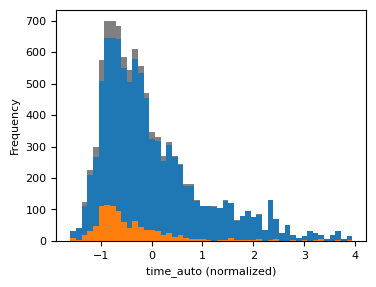

Strong regularity = 0.1019
Weak regularity = 0.9478


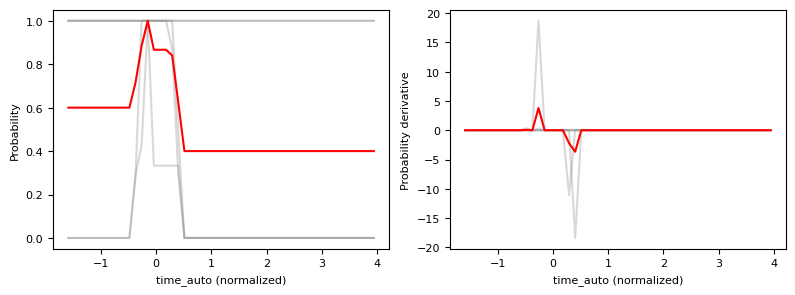

Penalty = 0.1
Model 1: test_loss = 227.6260, test_accuracy = 55.5%
Model 2: test_loss = 291.9594, test_accuracy = 61.0%
Model 3: test_loss = 269.5121, test_accuracy = 64.0%
Model 4: test_loss = 191.2586, test_accuracy = 53.5%
Model 5: test_loss = 374.2981, test_accuracy = 60.0%
Mean loss = 270.9308
Mean accuracy = 58.8%


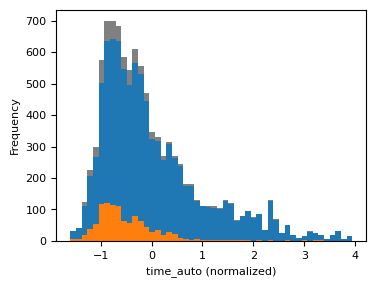

Strong regularity = 0.1095
Weak regularity = 0.9393


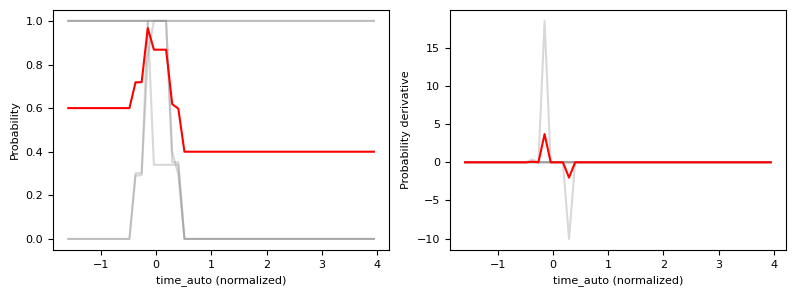

Penalty = 0.01
Model 1: test_loss = 197.4983, test_accuracy = 50.5%
Model 2: test_loss = 297.6866, test_accuracy = 49.0%
Model 3: test_loss = 285.1400, test_accuracy = 54.5%
Model 4: test_loss = 221.4512, test_accuracy = 46.0%
Model 5: test_loss = 241.0037, test_accuracy = 46.0%
Mean loss = 248.5559
Mean accuracy = 49.2%


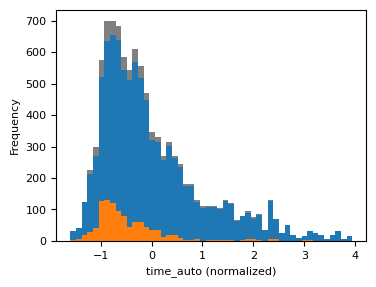

Strong regularity = 0.1043
Weak regularity = 0.9435


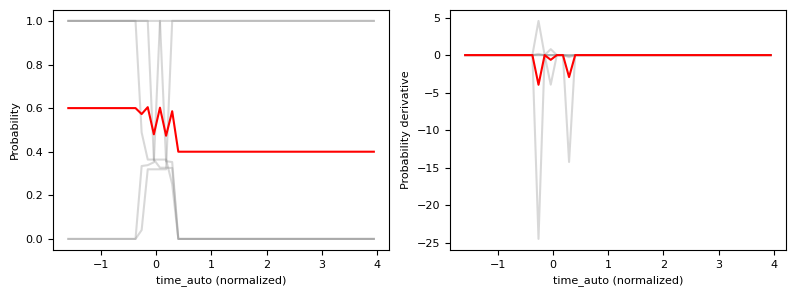

Penalty = 0.001
Model 1: test_loss = 16.1288, test_accuracy = 57.0%
Model 2: test_loss = 15.6934, test_accuracy = 73.5%
Model 3: test_loss = 51.2363, test_accuracy = 64.0%
Model 4: test_loss = 55.0011, test_accuracy = 75.0%
Model 5: test_loss = 33.6977, test_accuracy = 57.5%
Mean loss = 34.3515
Mean accuracy = 65.4%


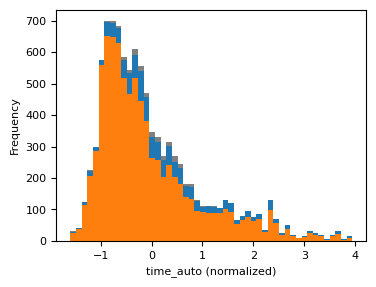

Strong regularity = 0.8472
Weak regularity = 0.9802


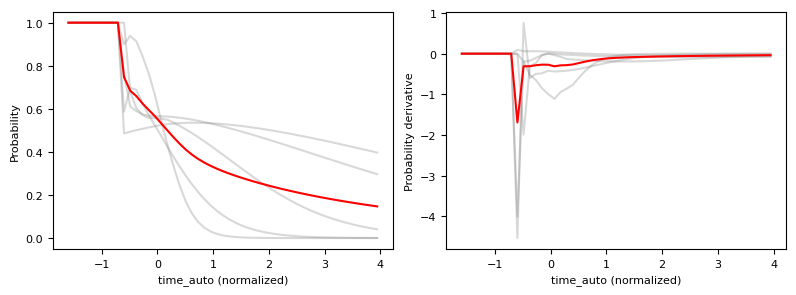

Penalty = 0.0001
Model 1: test_loss = 0.8223, test_accuracy = 73.0%
Model 2: test_loss = 0.7373, test_accuracy = 74.0%
Model 3: test_loss = 0.9135, test_accuracy = 74.0%
Model 4: test_loss = 0.7574, test_accuracy = 75.0%
Model 5: test_loss = 1.0719, test_accuracy = 73.5%
Mean loss = 0.8605
Mean accuracy = 73.9%


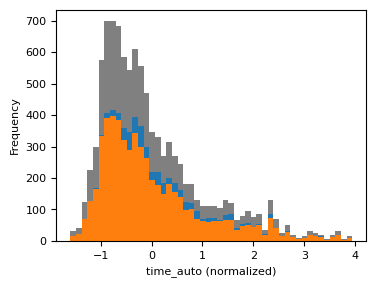

Strong regularity = 0.5581
Weak regularity = 0.6243


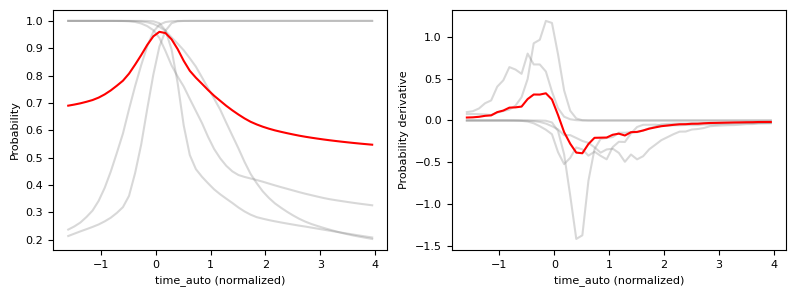

Penalty = 1e-05
Model 1: test_loss = 0.6896, test_accuracy = 75.5%
Model 2: test_loss = 0.6809, test_accuracy = 75.0%
Model 3: test_loss = 0.7004, test_accuracy = 74.0%
Model 4: test_loss = 0.6810, test_accuracy = 73.0%
Model 5: test_loss = 0.7076, test_accuracy = 76.5%
Mean loss = 0.6919
Mean accuracy = 74.8%


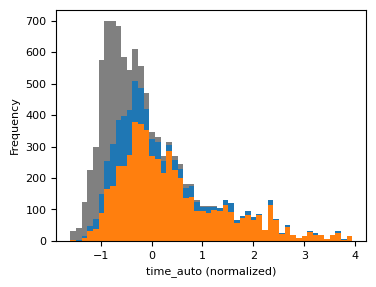

Strong regularity = 0.5596
Weak regularity = 0.7187


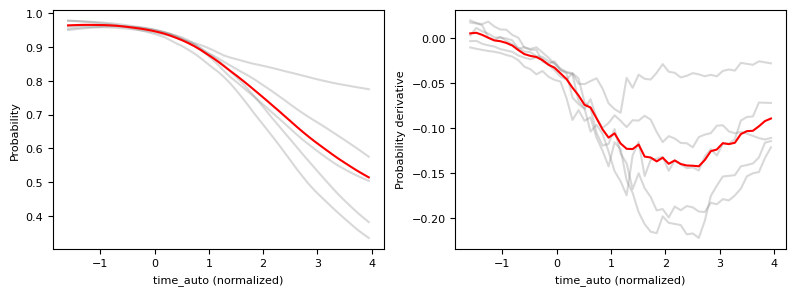

Model comparison:


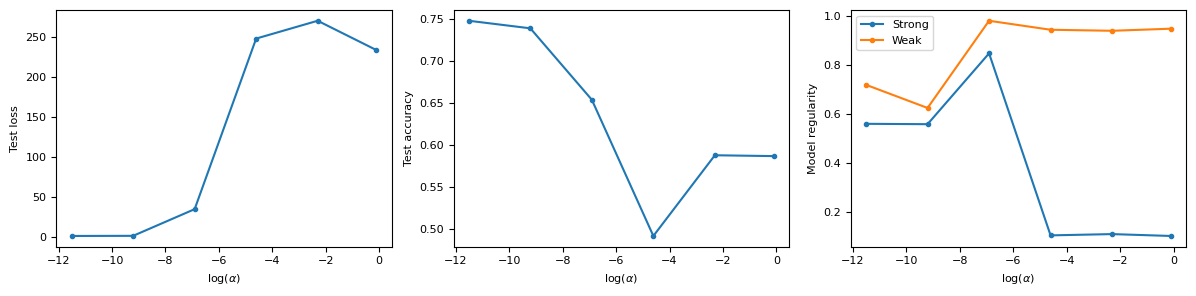

In [ ]:
# With "hard" sum
result('util', [.9, .1, 1e-2, 1e-3, 1e-4, 1e-5], [0, 1, 0])

Penalty = 0.9
Model 1: test_loss = 0.6879, test_accuracy = 76.0%
Model 2: test_loss = 0.6954, test_accuracy = 76.0%
Model 3: test_loss = 0.6897, test_accuracy = 75.0%
Model 4: test_loss = 0.6999, test_accuracy = 76.0%
Model 5: test_loss = 0.6903, test_accuracy = 76.5%
Mean loss = 0.6926
Mean accuracy = 75.9%


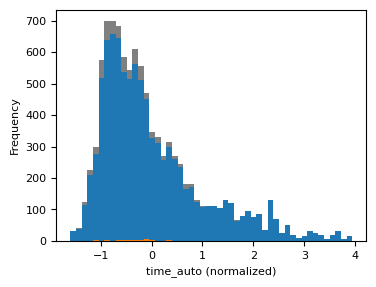

Strong regularity = 0.0042
Weak regularity = 0.9439


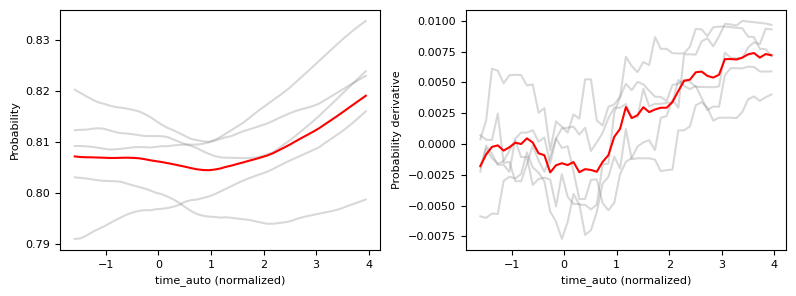

Penalty = 0.1
Model 1: test_loss = 0.6892, test_accuracy = 74.5%
Model 2: test_loss = 0.6842, test_accuracy = 74.5%
Model 3: test_loss = 0.6870, test_accuracy = 75.5%
Model 4: test_loss = 0.6804, test_accuracy = 75.0%
Model 5: test_loss = 0.6836, test_accuracy = 76.0%
Mean loss = 0.6849
Mean accuracy = 75.1%


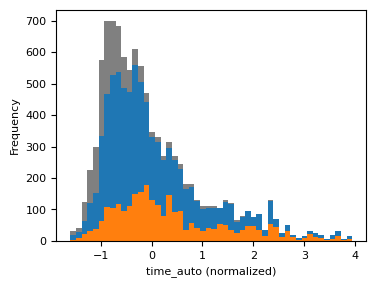

Strong regularity = 0.2655
Weak regularity = 0.8409


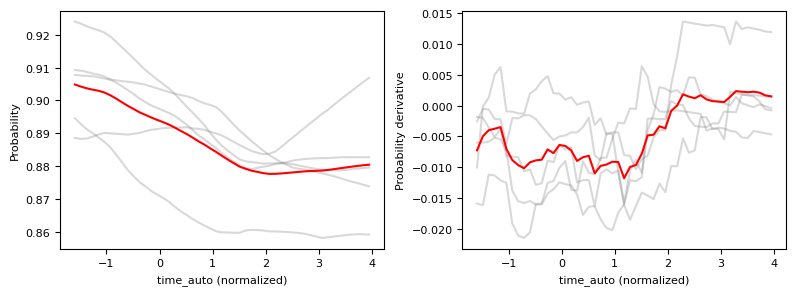

Penalty = 0.01
Model 1: test_loss = 0.6883, test_accuracy = 74.5%
Model 2: test_loss = 0.6771, test_accuracy = 74.5%
Model 3: test_loss = 0.6950, test_accuracy = 76.0%
Model 4: test_loss = 0.6797, test_accuracy = 74.0%
Model 5: test_loss = 0.6875, test_accuracy = 76.0%
Mean loss = 0.6855
Mean accuracy = 75.0%


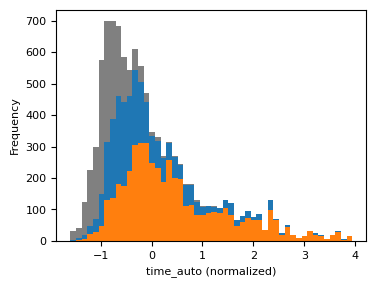

Strong regularity = 0.4786
Weak regularity = 0.7658


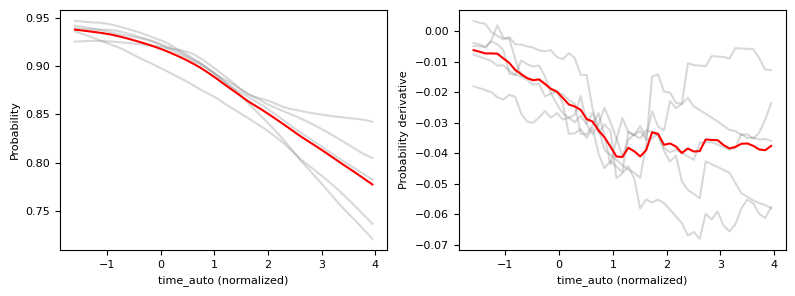

Penalty = 0.001
Model 1: test_loss = 0.6879, test_accuracy = 74.0%
Model 2: test_loss = 0.6790, test_accuracy = 74.5%
Model 3: test_loss = 0.6918, test_accuracy = 74.0%
Model 4: test_loss = 0.6817, test_accuracy = 75.0%
Model 5: test_loss = 0.6950, test_accuracy = 76.5%
Mean loss = 0.6871
Mean accuracy = 74.8%


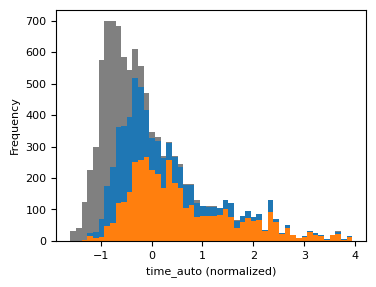

Strong regularity = 0.4029
Weak regularity = 0.6862


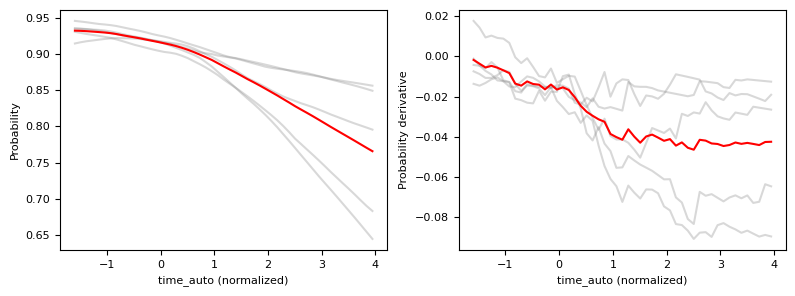

Penalty = 0.0001
Model 1: test_loss = 0.6870, test_accuracy = 75.0%
Model 2: test_loss = 0.6807, test_accuracy = 75.0%
Model 3: test_loss = 0.6931, test_accuracy = 74.0%
Model 4: test_loss = 0.6866, test_accuracy = 75.0%
Model 5: test_loss = 0.7020, test_accuracy = 76.0%
Mean loss = 0.6899
Mean accuracy = 75.0%


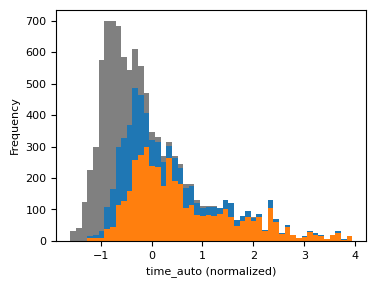

Strong regularity = 0.4170
Weak regularity = 0.6422


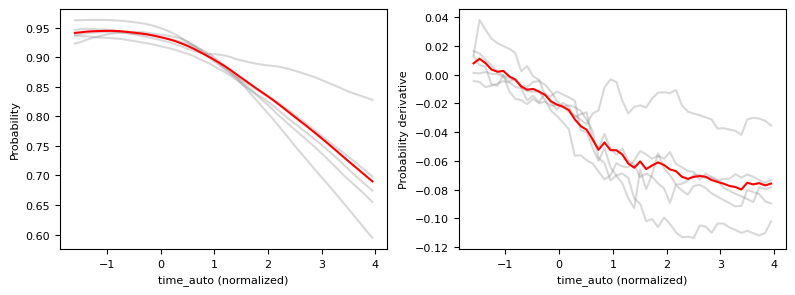

Penalty = 1e-05
Model 1: test_loss = 0.6888, test_accuracy = 76.0%
Model 2: test_loss = 0.6817, test_accuracy = 75.5%
Model 3: test_loss = 0.6966, test_accuracy = 74.0%
Model 4: test_loss = 0.6847, test_accuracy = 74.0%
Model 5: test_loss = 0.7043, test_accuracy = 76.0%
Mean loss = 0.6912
Mean accuracy = 75.1%


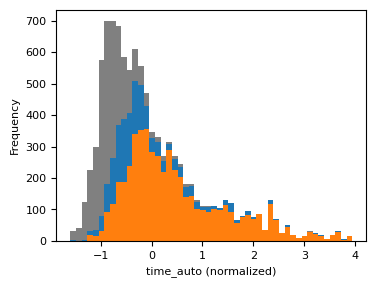

Strong regularity = 0.5241
Weak regularity = 0.6946


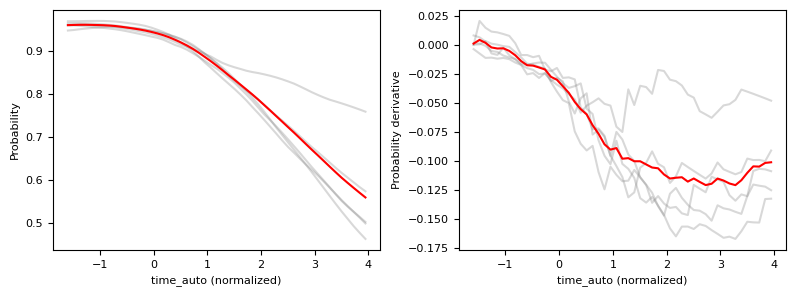

Model comparison:


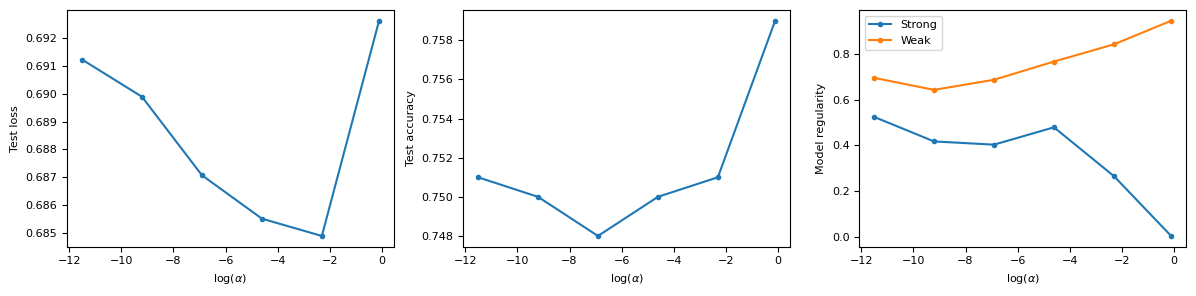

In [ ]:
# With norm
result('util', [.9, .1, 1e-2, 1e-3, 1e-4, 1e-5], [0, 0, 1])

## Probability gradient regularization
The choice probability of alternative $i$ by decision-maker $n$ is
$$
P_{ni}=\frac{e^{V_{ni}}}{\sum_{j\in\mathcal{C}_n}e^{V_{nj}}}
$$

Then we have
$$
\frac{\partial P_{ni}}{\partial\mathbf{x}_{ni}}=\frac{e^{V_{ni}}\left(\sum_{j\in\mathcal{C}_n}e^{V_{nj}}-e^{V_{ni}}\right)}{\left(\sum_{j\in\mathcal{C}_n}e^{V_{nj}}\right)^2}\frac{\partial V_{ni}}{\partial\mathbf{x}_{ni}}=P_{ni}\left(1-P_{ni}\right)\frac{\partial V_{ni}}{\partial\mathbf{x}_{ni}}
$$

Penalty = 0.9
Model 1: test_loss = 1.3047, test_accuracy = 54.5%
Model 2: test_loss = 1.5669, test_accuracy = 36.0%
Model 3: test_loss = 1.2182, test_accuracy = 68.0%
Model 4: test_loss = 1.3354, test_accuracy = 49.5%
Model 5: test_loss = 1.1536, test_accuracy = 65.0%
Mean loss = 1.3158
Mean accuracy = 54.6%


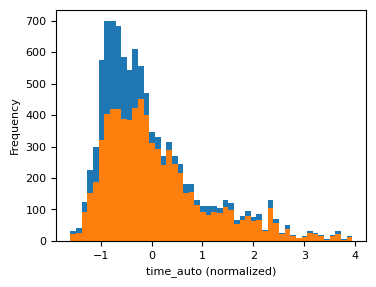

Strong regularity = 0.7400
Weak regularity = 1.0000


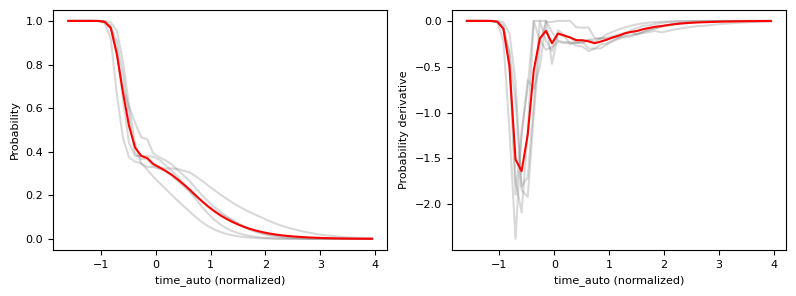

Penalty = 0.1
Model 1: test_loss = 1.4037, test_accuracy = 43.0%
Model 2: test_loss = 1.2109, test_accuracy = 66.5%
Model 3: test_loss = 1.3804, test_accuracy = 41.5%
Model 4: test_loss = 1.1307, test_accuracy = 69.0%
Model 5: test_loss = 1.1715, test_accuracy = 62.5%
Mean loss = 1.2594
Mean accuracy = 56.5%


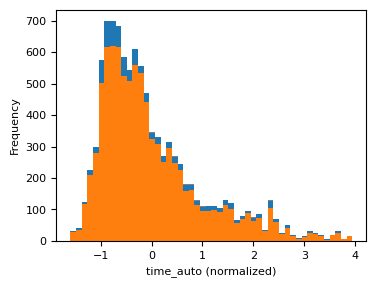

Strong regularity = 0.9053
Weak regularity = 0.9980


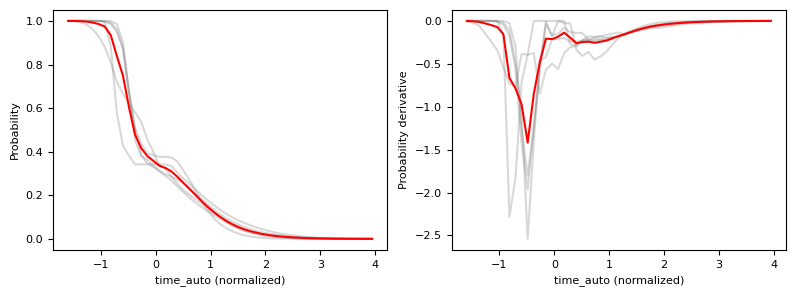

Penalty = 0.01
Model 1: test_loss = 1.1188, test_accuracy = 71.0%
Model 2: test_loss = 1.0697, test_accuracy = 72.5%
Model 3: test_loss = 1.1425, test_accuracy = 71.5%
Model 4: test_loss = 1.2215, test_accuracy = 61.5%
Model 5: test_loss = 1.2048, test_accuracy = 54.0%
Mean loss = 1.1515
Mean accuracy = 66.1%


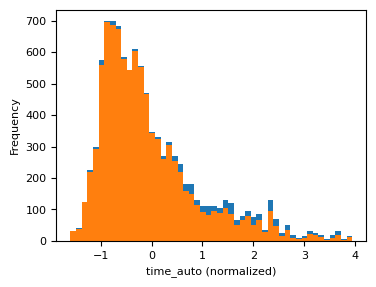

Strong regularity = 0.9380
Weak regularity = 1.0000


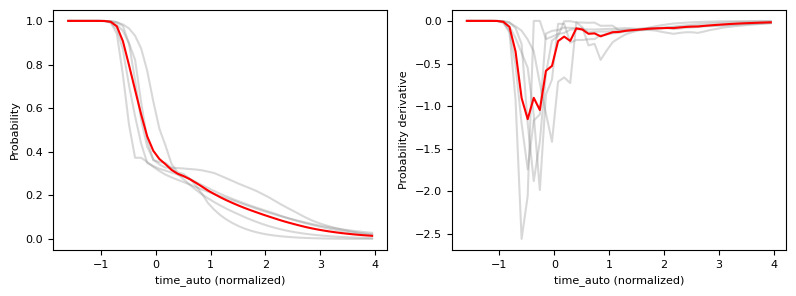

Penalty = 0.001
Model 1: test_loss = 0.7389, test_accuracy = 72.0%
Model 2: test_loss = 0.7325, test_accuracy = 71.5%
Model 3: test_loss = 0.7407, test_accuracy = 71.5%
Model 4: test_loss = 0.7416, test_accuracy = 72.5%
Model 5: test_loss = 0.7211, test_accuracy = 75.0%
Mean loss = 0.7350
Mean accuracy = 72.5%


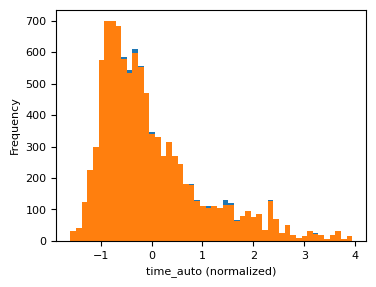

Strong regularity = 0.9923
Weak regularity = 1.0000


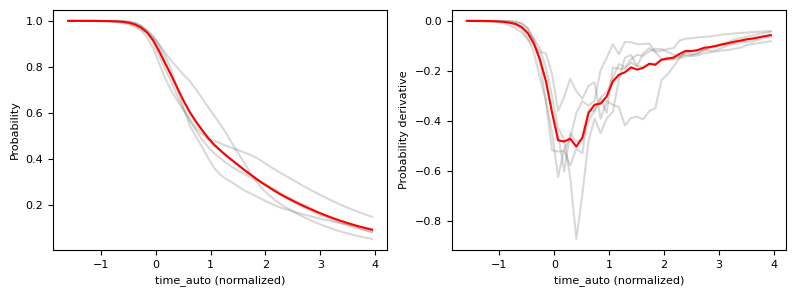

Penalty = 0.0001
Model 1: test_loss = 0.6885, test_accuracy = 75.5%
Model 2: test_loss = 0.6794, test_accuracy = 74.5%
Model 3: test_loss = 0.6970, test_accuracy = 74.0%
Model 4: test_loss = 0.6834, test_accuracy = 74.0%
Model 5: test_loss = 0.7038, test_accuracy = 75.5%
Mean loss = 0.6904
Mean accuracy = 74.7%


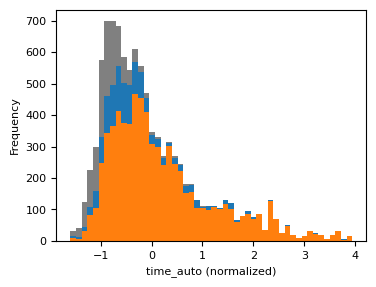

Strong regularity = 0.7199
Weak regularity = 0.8548


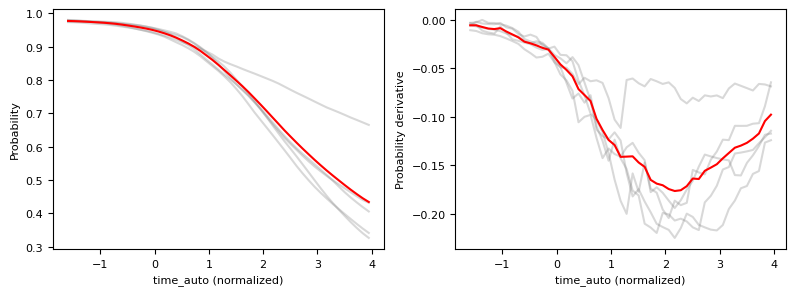

Penalty = 1e-05
Model 1: test_loss = 0.6884, test_accuracy = 75.0%
Model 2: test_loss = 0.6816, test_accuracy = 75.0%
Model 3: test_loss = 0.6978, test_accuracy = 73.5%
Model 4: test_loss = 0.6842, test_accuracy = 73.5%
Model 5: test_loss = 0.7045, test_accuracy = 76.0%
Mean loss = 0.6913
Mean accuracy = 74.6%


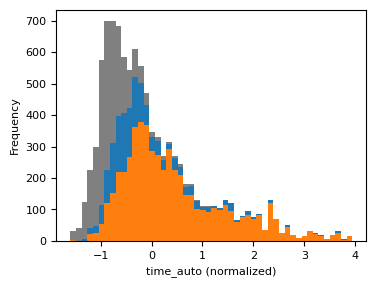

Strong regularity = 0.5537
Weak regularity = 0.7208


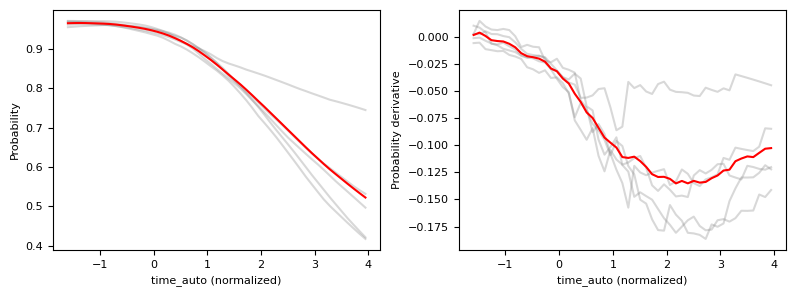

Model comparison:


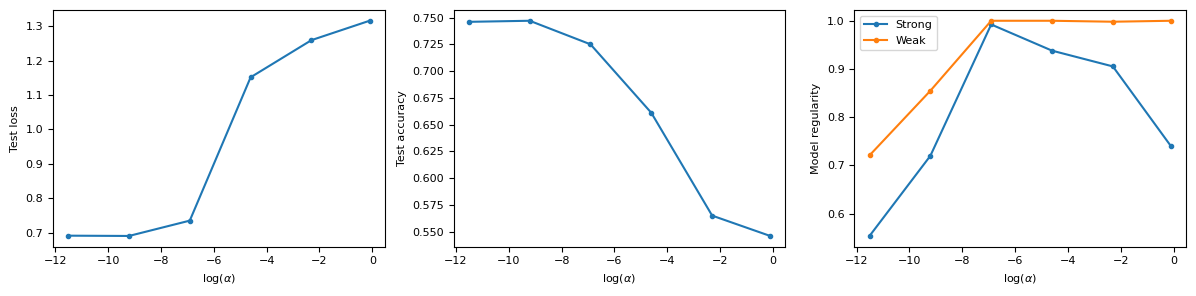

In [ ]:
# With "soft" sum
result('prob', [.9, .1, 1e-2, 1e-3, 1e-4, 1e-5], [1, 0, 0])

Penalty = 0.9
Model 1: test_loss = 1.1938, test_accuracy = 66.5%
Model 2: test_loss = 1.0322, test_accuracy = 72.0%
Model 3: test_loss = 1.1397, test_accuracy = 70.0%
Model 4: test_loss = 1.3055, test_accuracy = 58.5%
Model 5: test_loss = 1.1899, test_accuracy = 71.5%
Mean loss = 1.1722
Mean accuracy = 67.7%


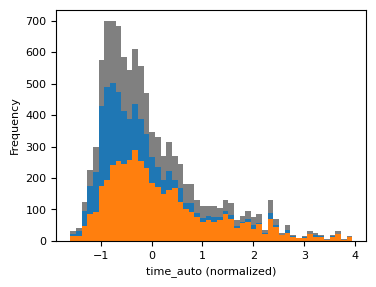

Strong regularity = 0.4586
Weak regularity = 0.7137


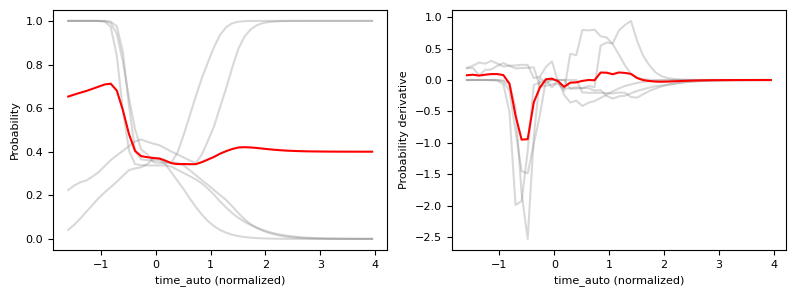

Penalty = 0.1
Model 1: test_loss = 1.0476, test_accuracy = 71.0%
Model 2: test_loss = 1.3067, test_accuracy = 55.5%
Model 3: test_loss = 1.2138, test_accuracy = 73.0%
Model 4: test_loss = 1.1779, test_accuracy = 67.0%
Model 5: test_loss = 1.3389, test_accuracy = 54.5%
Mean loss = 1.2170
Mean accuracy = 64.2%


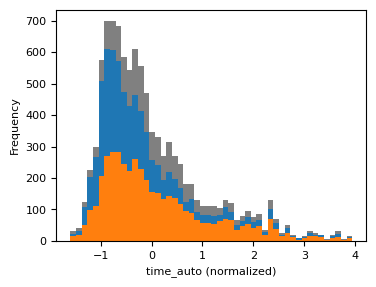

Strong regularity = 0.4437
Weak regularity = 0.7918


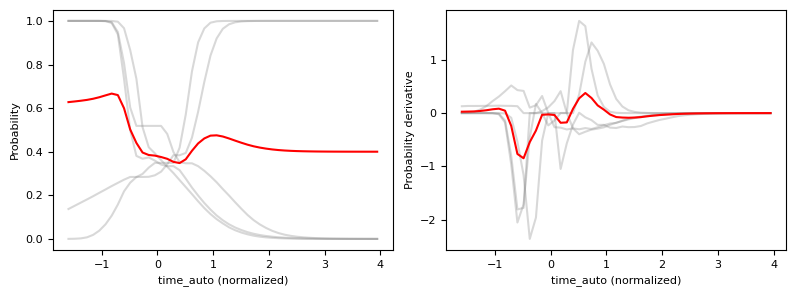

Penalty = 0.01
Model 1: test_loss = 1.1834, test_accuracy = 65.5%
Model 2: test_loss = 1.1279, test_accuracy = 71.0%
Model 3: test_loss = 1.1617, test_accuracy = 61.5%
Model 4: test_loss = 1.1115, test_accuracy = 71.5%
Model 5: test_loss = 1.1262, test_accuracy = 73.0%
Mean loss = 1.1422
Mean accuracy = 68.5%


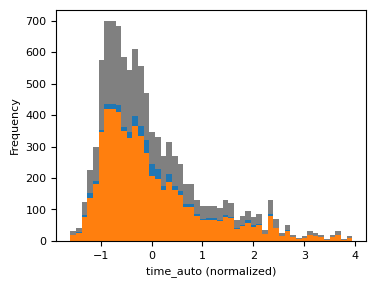

Strong regularity = 0.5996
Weak regularity = 0.6452


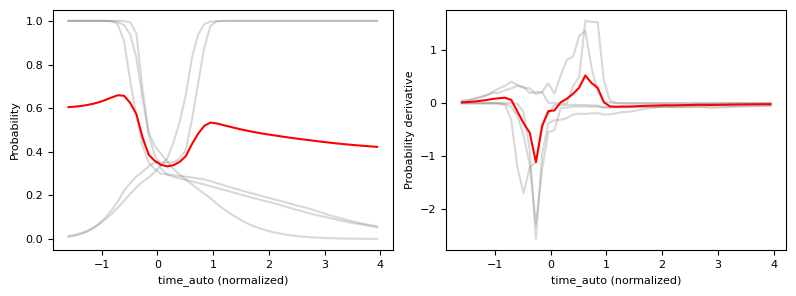

Penalty = 0.001
Model 1: test_loss = 0.7501, test_accuracy = 71.0%
Model 2: test_loss = 0.7097, test_accuracy = 73.5%
Model 3: test_loss = 0.7983, test_accuracy = 72.0%
Model 4: test_loss = 0.7533, test_accuracy = 69.5%
Model 5: test_loss = 0.7656, test_accuracy = 75.5%
Mean loss = 0.7554
Mean accuracy = 72.3%


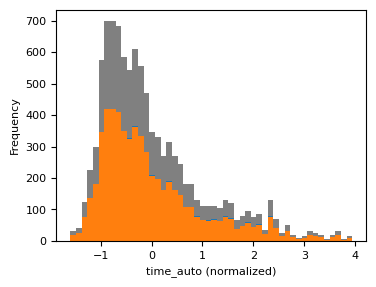

Strong regularity = 0.5971
Weak regularity = 0.6011


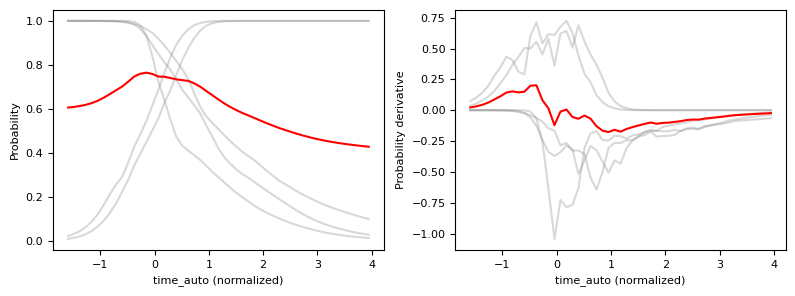

Penalty = 0.0001
Model 1: test_loss = 0.6898, test_accuracy = 75.5%
Model 2: test_loss = 0.6821, test_accuracy = 75.0%
Model 3: test_loss = 0.7024, test_accuracy = 74.0%
Model 4: test_loss = 0.6845, test_accuracy = 74.5%
Model 5: test_loss = 0.7043, test_accuracy = 76.0%
Mean loss = 0.6926
Mean accuracy = 75.0%


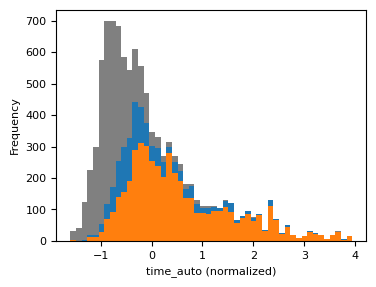

Strong regularity = 0.4721
Weak regularity = 0.6150


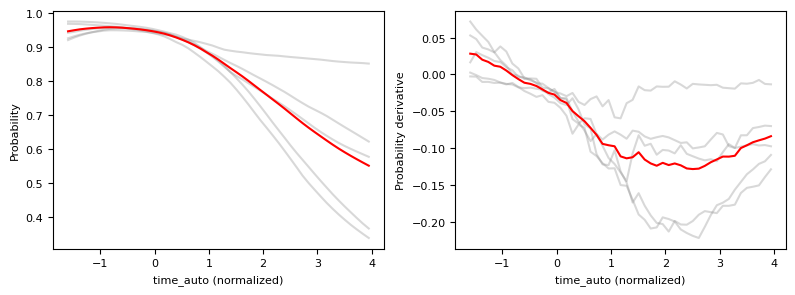

Penalty = 1e-05
Model 1: test_loss = 0.6886, test_accuracy = 76.0%
Model 2: test_loss = 0.6815, test_accuracy = 75.0%
Model 3: test_loss = 0.6974, test_accuracy = 74.0%
Model 4: test_loss = 0.6841, test_accuracy = 73.5%
Model 5: test_loss = 0.7060, test_accuracy = 76.5%
Mean loss = 0.6915
Mean accuracy = 75.0%


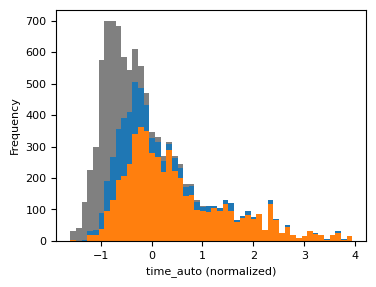

Strong regularity = 0.5302
Weak regularity = 0.6961


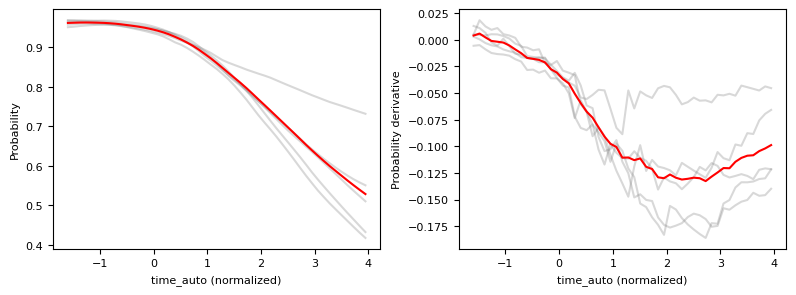

Model comparison:


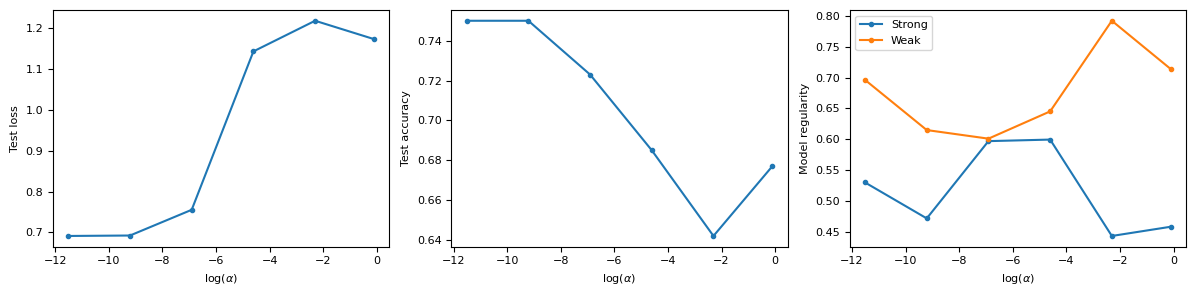

In [ ]:
# With "hard" sum
result('prob', [.9, .1, 1e-2, 1e-3, 1e-4, 1e-5], [0, 1, 0])

Penalty = 0.9
Model 1: test_loss = 1.1685, test_accuracy = 73.0%
Model 2: test_loss = 1.2792, test_accuracy = 13.5%
Model 3: test_loss = 1.2069, test_accuracy = 14.5%
Model 4: test_loss = 1.1819, test_accuracy = 73.5%
Model 5: test_loss = 1.1824, test_accuracy = 73.5%
Mean loss = 1.2038
Mean accuracy = 49.6%


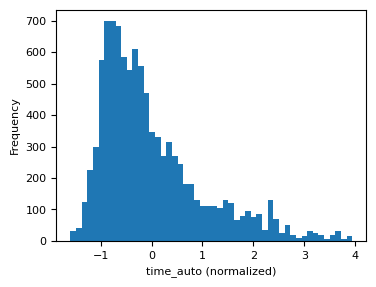

Strong regularity = 0.0000
Weak regularity = 1.0000


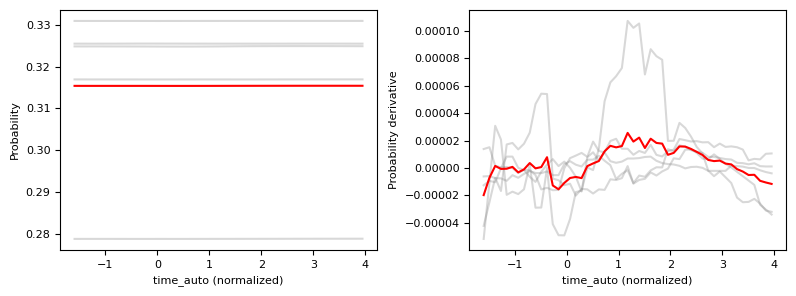

Penalty = 0.1
Model 1: test_loss = 0.6974, test_accuracy = 74.5%
Model 2: test_loss = 0.6979, test_accuracy = 76.0%
Model 3: test_loss = 0.6946, test_accuracy = 75.5%
Model 4: test_loss = 0.6926, test_accuracy = 76.0%
Model 5: test_loss = 0.6974, test_accuracy = 76.0%
Mean loss = 0.6960
Mean accuracy = 75.6%


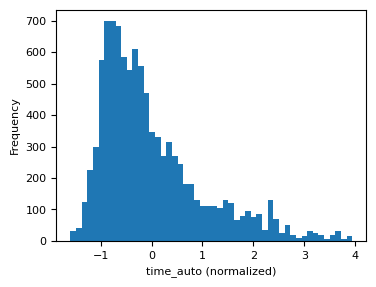

Strong regularity = 0.0000
Weak regularity = 1.0000


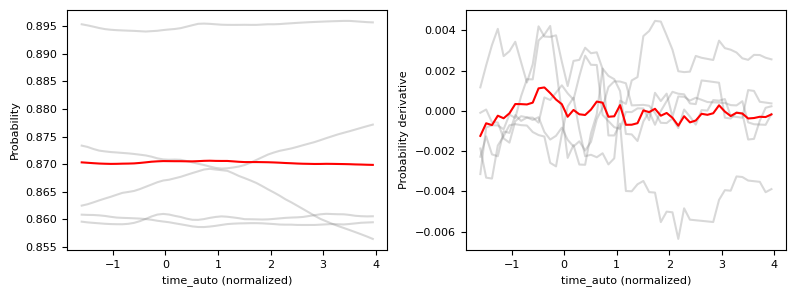

Penalty = 0.01
Model 1: test_loss = 0.6910, test_accuracy = 74.5%
Model 2: test_loss = 0.6881, test_accuracy = 75.0%
Model 3: test_loss = 0.6898, test_accuracy = 76.0%
Model 4: test_loss = 0.6851, test_accuracy = 74.5%
Model 5: test_loss = 0.6995, test_accuracy = 76.5%
Mean loss = 0.6907
Mean accuracy = 75.3%


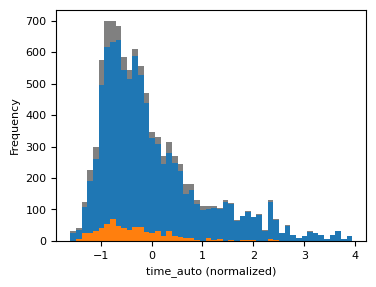

Strong regularity = 0.0693
Weak regularity = 0.9199


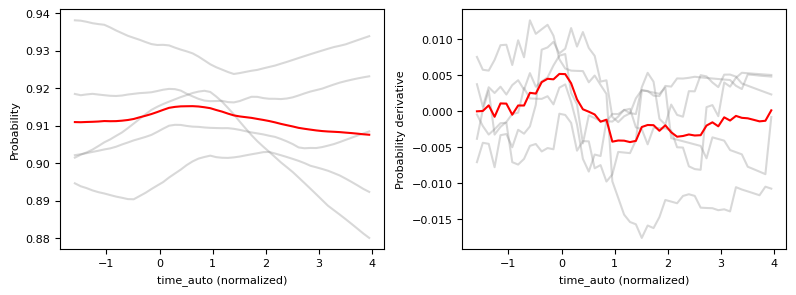

Penalty = 0.001
Model 1: test_loss = 0.6900, test_accuracy = 74.5%
Model 2: test_loss = 0.6828, test_accuracy = 74.5%
Model 3: test_loss = 0.6927, test_accuracy = 74.0%
Model 4: test_loss = 0.6917, test_accuracy = 74.5%
Model 5: test_loss = 0.7024, test_accuracy = 76.5%
Mean loss = 0.6919
Mean accuracy = 74.8%


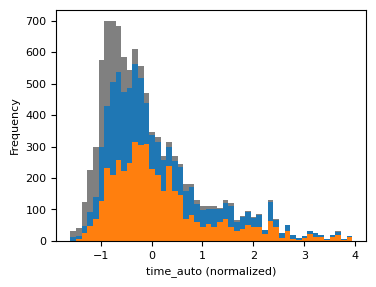

Strong regularity = 0.4523
Weak regularity = 0.8196


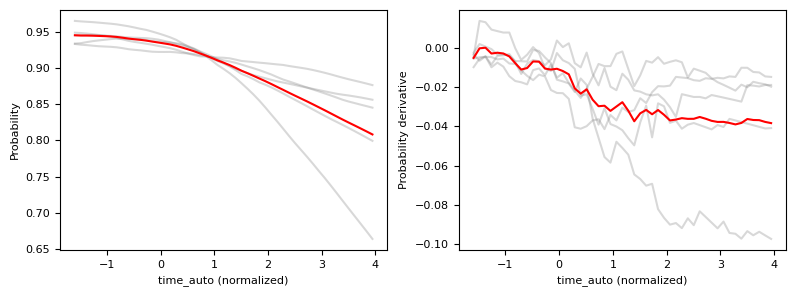

Penalty = 0.0001
Model 1: test_loss = 0.6879, test_accuracy = 75.0%
Model 2: test_loss = 0.6812, test_accuracy = 74.0%
Model 3: test_loss = 0.6949, test_accuracy = 73.5%
Model 4: test_loss = 0.6840, test_accuracy = 74.0%
Model 5: test_loss = 0.7035, test_accuracy = 75.5%
Mean loss = 0.6903
Mean accuracy = 74.4%


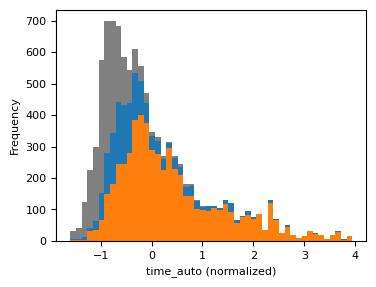

Strong regularity = 0.5749
Weak regularity = 0.7474


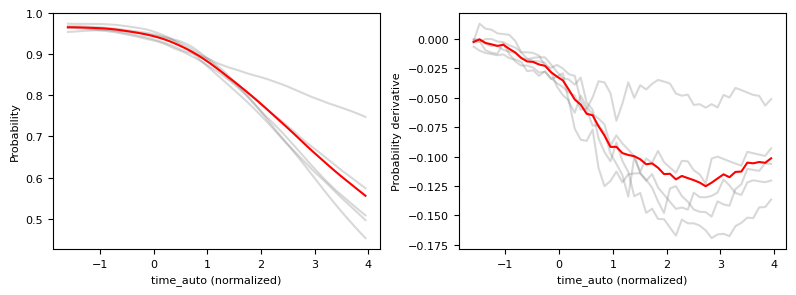

Penalty = 1e-05
Model 1: test_loss = 0.6884, test_accuracy = 75.5%
Model 2: test_loss = 0.6816, test_accuracy = 75.5%
Model 3: test_loss = 0.6990, test_accuracy = 74.0%
Model 4: test_loss = 0.6843, test_accuracy = 74.0%
Model 5: test_loss = 0.7060, test_accuracy = 76.0%
Mean loss = 0.6919
Mean accuracy = 75.0%


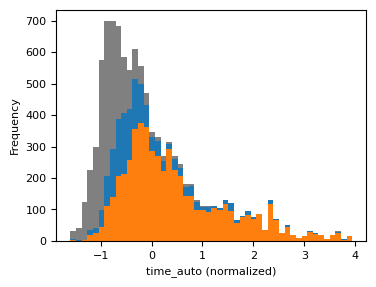

Strong regularity = 0.5443
Weak regularity = 0.7113


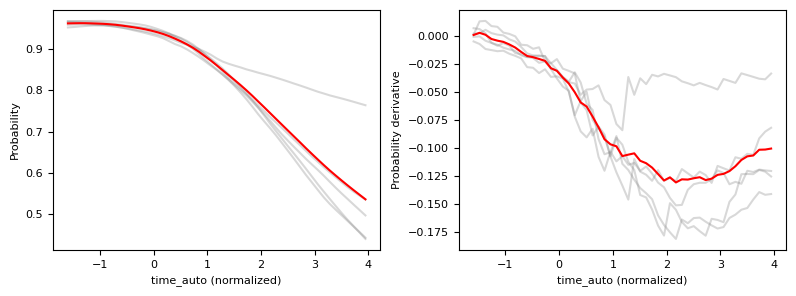

Model comparison:


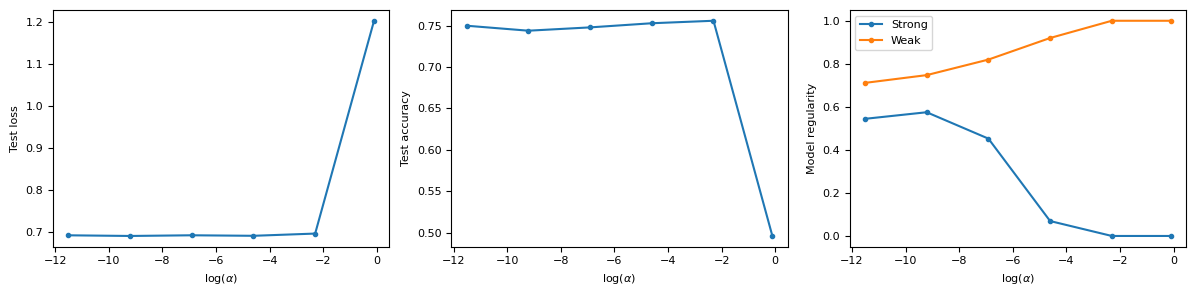

In [ ]:
# With norm
result('prob', [.9, .1, 1e-2, 1e-3, 1e-4, 1e-5], [0, 0, 1])

## Loss gradient regularization
The cross-entropy loss is
$$
\mathcal{H}=-\log\mathcal{L}=-\log\prod_{n,i}P_{ni}^{y_{ni}}=-\sum_{n,i}y_{ni}\log P_{ni}
$$

Then we have
$$
\frac{\partial\mathcal{H}}{\partial\mathbf{x}_{ni}}=-\sum_{n,i}\frac{y_{ni}}{P_{ni}}\frac{\partial P_{ni}}{\partial\mathbf{x}_{ni}}=-\sum_{n,i}y_{ni}\left(1-P_{ni}\right)\frac{\partial V_{ni}}{\partial\mathbf{x}_{ni}}
$$

Penalty = 0.9
Model 1: test_loss = 1055.0443, test_accuracy = 10.5%
Model 2: test_loss = 1369.2983, test_accuracy = 18.5%
Model 3: test_loss = 1148.2832, test_accuracy = 22.0%
Model 4: test_loss = 916.0171, test_accuracy = 14.5%
Model 5: test_loss = 1425.0953, test_accuracy = 6.0%
Mean loss = 1182.7477
Mean accuracy = 14.3%


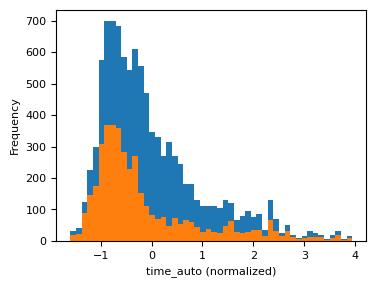

Strong regularity = 0.4095
Weak regularity = 1.0000


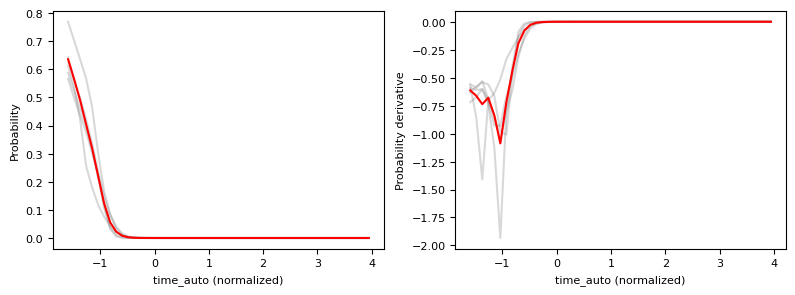

Penalty = 0.5
Model 1: test_loss = 18.6154, test_accuracy = 24.5%
Model 2: test_loss = 69.2307, test_accuracy = 23.5%
Model 3: test_loss = 32.7144, test_accuracy = 23.0%
Model 4: test_loss = 41.3494, test_accuracy = 36.5%
Model 5: test_loss = 14.5391, test_accuracy = 19.5%
Mean loss = 35.2898
Mean accuracy = 25.4%


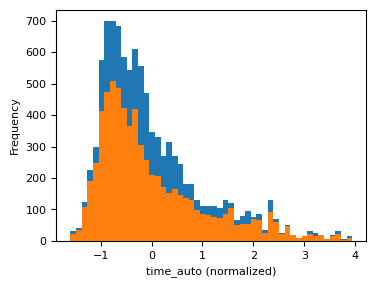

Strong regularity = 0.6871
Weak regularity = 1.0000


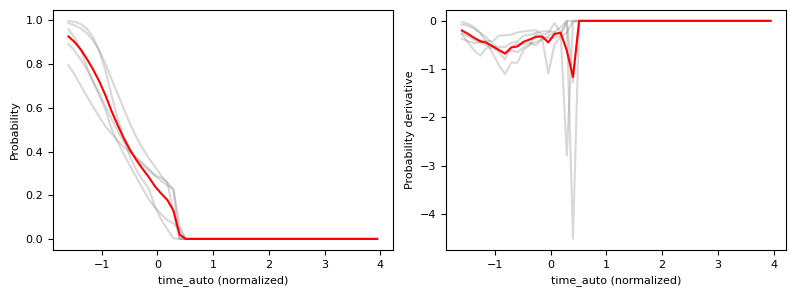

Penalty = 0.1
Model 1: test_loss = 0.6795, test_accuracy = 75.0%
Model 2: test_loss = 0.6746, test_accuracy = 75.0%
Model 3: test_loss = 0.6933, test_accuracy = 74.0%
Model 4: test_loss = 0.6756, test_accuracy = 75.0%
Model 5: test_loss = 0.6953, test_accuracy = 76.5%
Mean loss = 0.6837
Mean accuracy = 75.1%


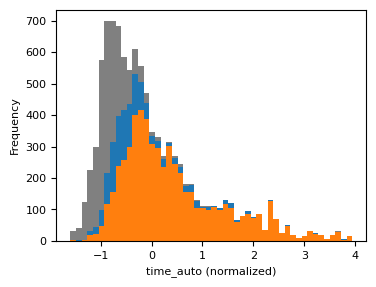

Strong regularity = 0.5879
Weak regularity = 0.7225


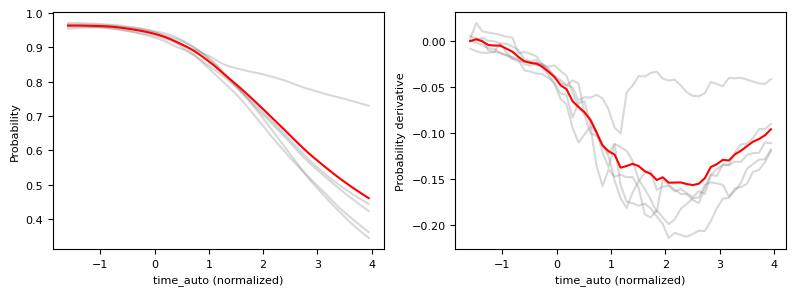

Penalty = 0.01
Model 1: test_loss = 0.6875, test_accuracy = 75.0%
Model 2: test_loss = 0.6817, test_accuracy = 75.5%
Model 3: test_loss = 0.6976, test_accuracy = 74.0%
Model 4: test_loss = 0.6824, test_accuracy = 74.0%
Model 5: test_loss = 0.7033, test_accuracy = 76.5%
Mean loss = 0.6905
Mean accuracy = 75.0%


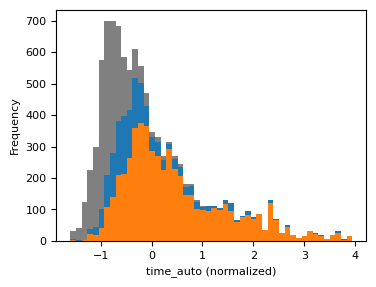

Strong regularity = 0.5474
Weak regularity = 0.7093


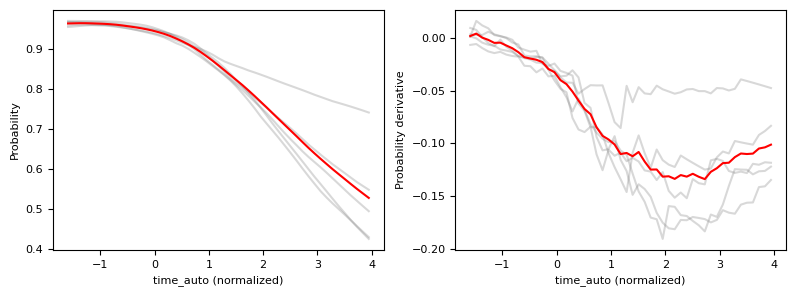

Penalty = 0.001
Model 1: test_loss = 0.6887, test_accuracy = 76.0%
Model 2: test_loss = 0.6808, test_accuracy = 74.5%
Model 3: test_loss = 0.6960, test_accuracy = 74.0%
Model 4: test_loss = 0.6842, test_accuracy = 74.0%
Model 5: test_loss = 0.7059, test_accuracy = 75.5%
Mean loss = 0.6911
Mean accuracy = 74.8%


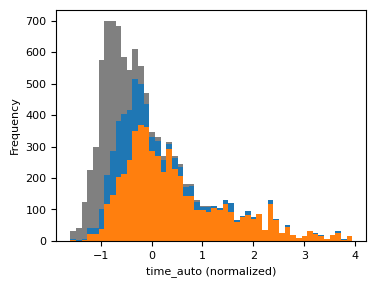

Strong regularity = 0.5432
Weak regularity = 0.7109


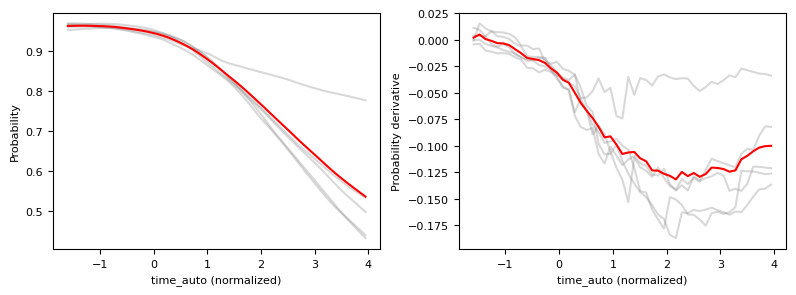

Penalty = 0.0001
Model 1: test_loss = 0.6886, test_accuracy = 75.5%
Model 2: test_loss = 0.6811, test_accuracy = 75.0%
Model 3: test_loss = 0.6982, test_accuracy = 74.0%
Model 4: test_loss = 0.6822, test_accuracy = 74.0%
Model 5: test_loss = 0.7060, test_accuracy = 76.0%
Mean loss = 0.6912
Mean accuracy = 74.9%


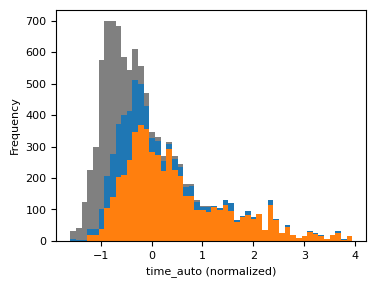

Strong regularity = 0.5389
Weak regularity = 0.7057


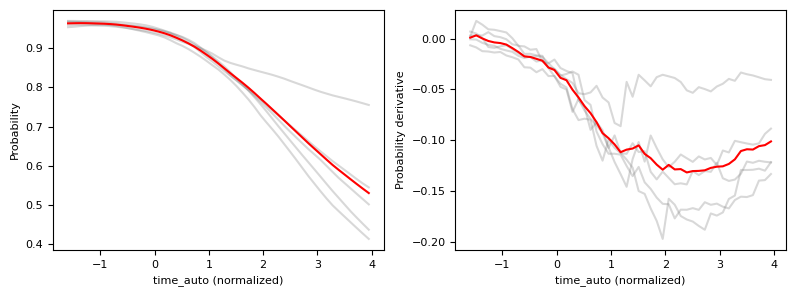

Model comparison:


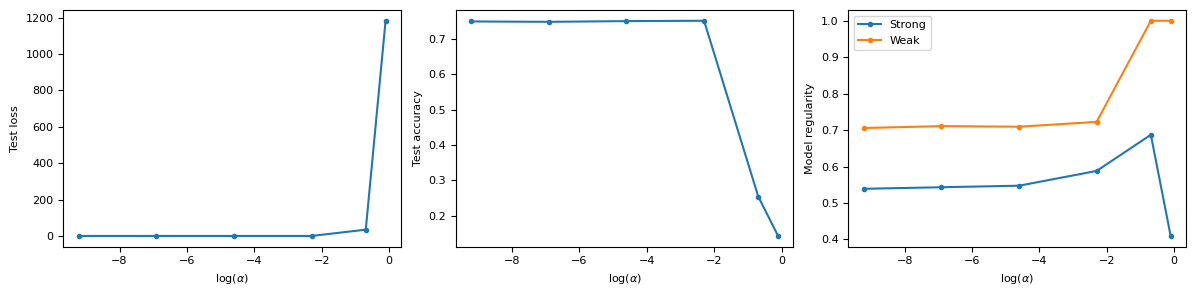

In [ ]:
# With "soft" sum
result('loss', [.9, .5, .1, 1e-2, 1e-3, 1e-4], [1, 0, 0])

Penalty = 0.9
Model 1: test_loss = 0.6940, test_accuracy = 75.5%
Model 2: test_loss = 0.6974, test_accuracy = 76.5%
Model 3: test_loss = 0.6985, test_accuracy = 75.5%
Model 4: test_loss = 0.6950, test_accuracy = 77.0%
Model 5: test_loss = 0.6956, test_accuracy = 77.0%
Mean loss = 0.6961
Mean accuracy = 76.3%


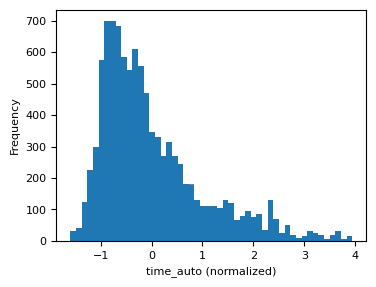

Strong regularity = 0.0000
Weak regularity = 0.9999


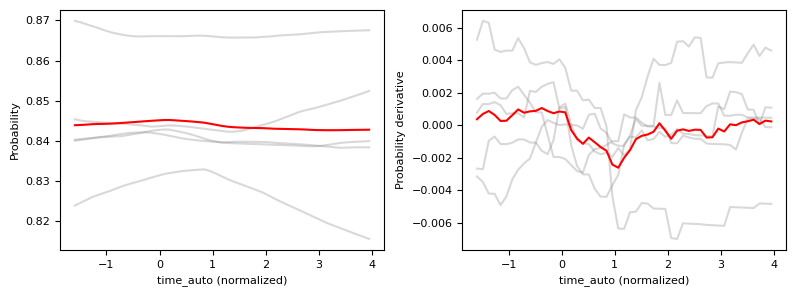

Penalty = 0.5
Model 1: test_loss = 0.6872, test_accuracy = 75.5%
Model 2: test_loss = 0.6900, test_accuracy = 75.0%
Model 3: test_loss = 0.6881, test_accuracy = 76.0%
Model 4: test_loss = 0.6834, test_accuracy = 75.0%
Model 5: test_loss = 0.6971, test_accuracy = 77.0%
Mean loss = 0.6892
Mean accuracy = 75.7%


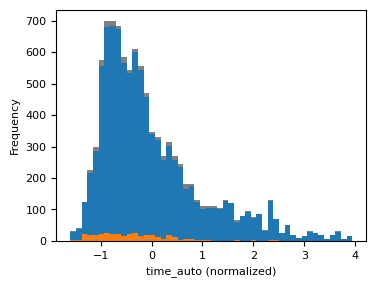

Strong regularity = 0.0354
Weak regularity = 0.9709


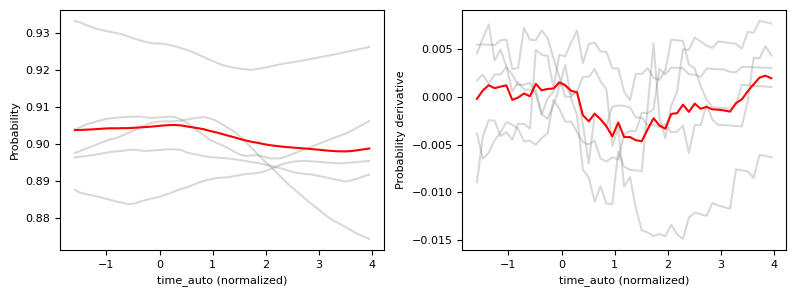

Penalty = 0.1
Model 1: test_loss = 0.6850, test_accuracy = 75.0%
Model 2: test_loss = 0.6816, test_accuracy = 74.5%
Model 3: test_loss = 0.6865, test_accuracy = 74.0%
Model 4: test_loss = 0.6880, test_accuracy = 75.0%
Model 5: test_loss = 0.6974, test_accuracy = 76.0%
Mean loss = 0.6877
Mean accuracy = 74.9%


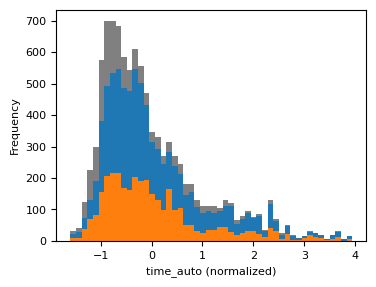

Strong regularity = 0.3317
Weak regularity = 0.8252


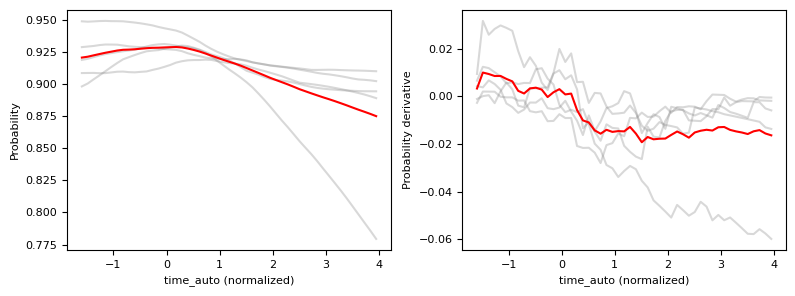

Penalty = 0.01
Model 1: test_loss = 0.6868, test_accuracy = 76.0%
Model 2: test_loss = 0.6803, test_accuracy = 74.5%
Model 3: test_loss = 0.6909, test_accuracy = 74.0%
Model 4: test_loss = 0.6862, test_accuracy = 74.5%
Model 5: test_loss = 0.7042, test_accuracy = 76.0%
Mean loss = 0.6897
Mean accuracy = 75.0%


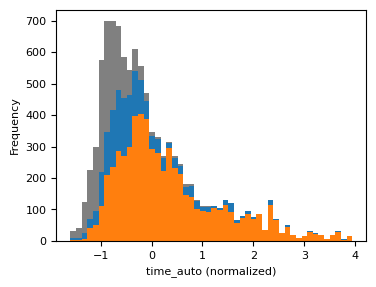

Strong regularity = 0.6060
Weak regularity = 0.7873


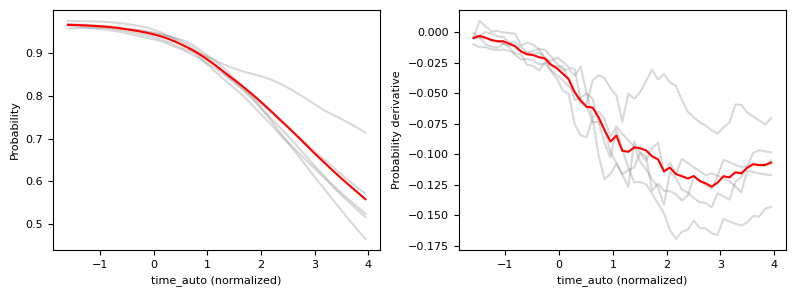

Penalty = 0.001
Model 1: test_loss = 0.6885, test_accuracy = 75.5%
Model 2: test_loss = 0.6813, test_accuracy = 75.5%
Model 3: test_loss = 0.6968, test_accuracy = 74.0%
Model 4: test_loss = 0.6839, test_accuracy = 74.0%
Model 5: test_loss = 0.7056, test_accuracy = 75.5%
Mean loss = 0.6912
Mean accuracy = 74.9%


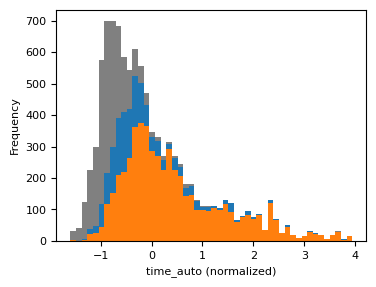

Strong regularity = 0.5491
Weak regularity = 0.7175


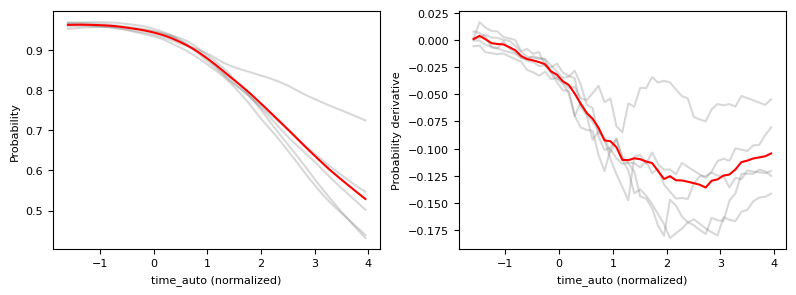

Penalty = 0.0001
Model 1: test_loss = 0.6889, test_accuracy = 75.0%
Model 2: test_loss = 0.6819, test_accuracy = 75.0%
Model 3: test_loss = 0.6978, test_accuracy = 74.0%
Model 4: test_loss = 0.6842, test_accuracy = 74.0%
Model 5: test_loss = 0.7051, test_accuracy = 75.5%
Mean loss = 0.6916
Mean accuracy = 74.7%


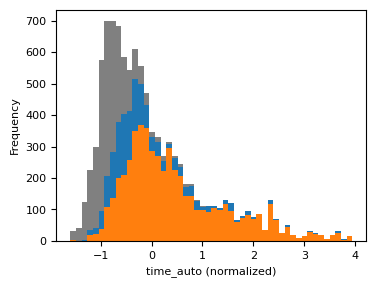

Strong regularity = 0.5390
Weak regularity = 0.7072


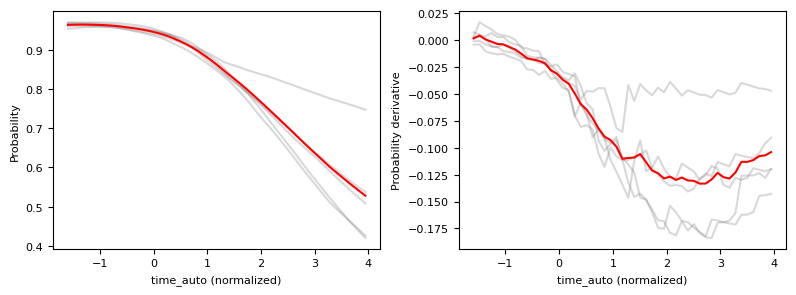

Model comparison:


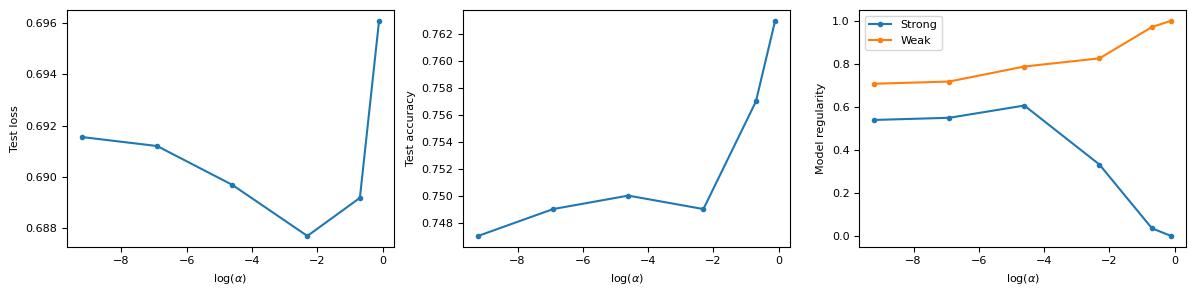

In [ ]:
# With "hard" sum
result('loss', [.9, .5, .1, 1e-2, 1e-3, 1e-4], [0, 1, 0])

Penalty = 0.9
Model 1: test_loss = 0.6842, test_accuracy = 74.5%
Model 2: test_loss = 0.6853, test_accuracy = 75.0%
Model 3: test_loss = 0.6838, test_accuracy = 76.0%
Model 4: test_loss = 0.6830, test_accuracy = 74.0%
Model 5: test_loss = 0.6896, test_accuracy = 76.5%
Mean loss = 0.6852
Mean accuracy = 75.2%


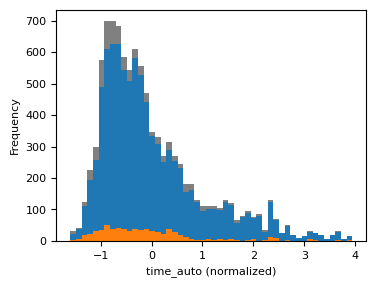

Strong regularity = 0.0682
Weak regularity = 0.9168


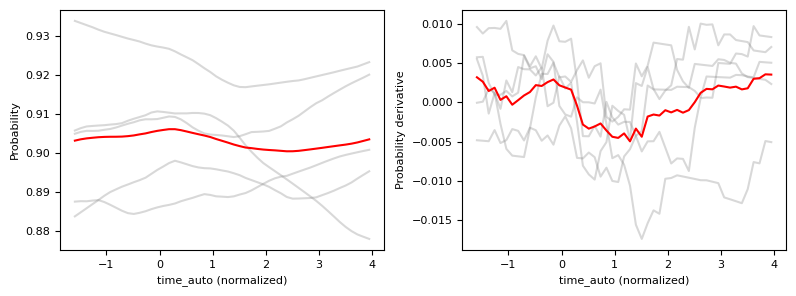

Penalty = 0.5
Model 1: test_loss = 0.6835, test_accuracy = 76.0%
Model 2: test_loss = 0.6777, test_accuracy = 75.0%
Model 3: test_loss = 0.6847, test_accuracy = 74.5%
Model 4: test_loss = 0.6852, test_accuracy = 75.0%
Model 5: test_loss = 0.6969, test_accuracy = 76.0%
Mean loss = 0.6856
Mean accuracy = 75.3%


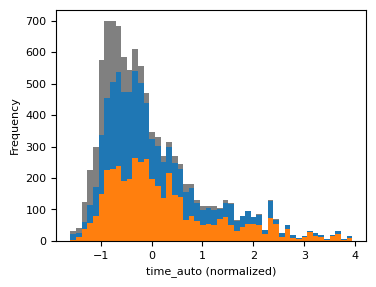

Strong regularity = 0.4321
Weak regularity = 0.8276


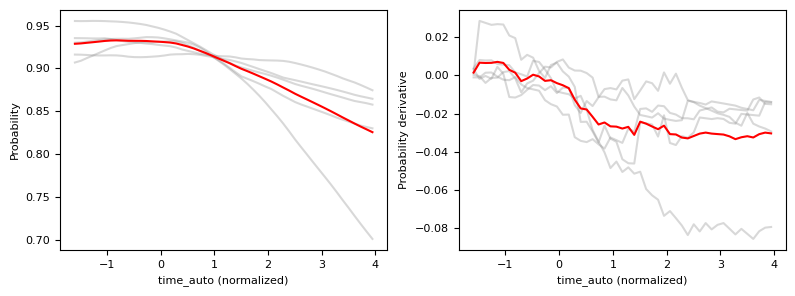

Penalty = 0.1
Model 1: test_loss = 0.6857, test_accuracy = 75.0%
Model 2: test_loss = 0.6792, test_accuracy = 74.5%
Model 3: test_loss = 0.6909, test_accuracy = 74.0%
Model 4: test_loss = 0.6819, test_accuracy = 73.5%
Model 5: test_loss = 0.7030, test_accuracy = 75.5%
Mean loss = 0.6881
Mean accuracy = 74.5%


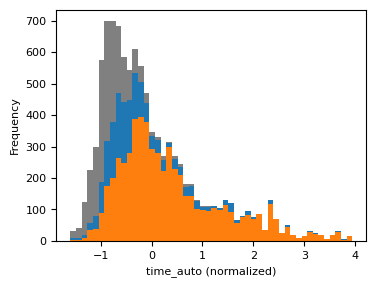

Strong regularity = 0.5855
Weak regularity = 0.7671


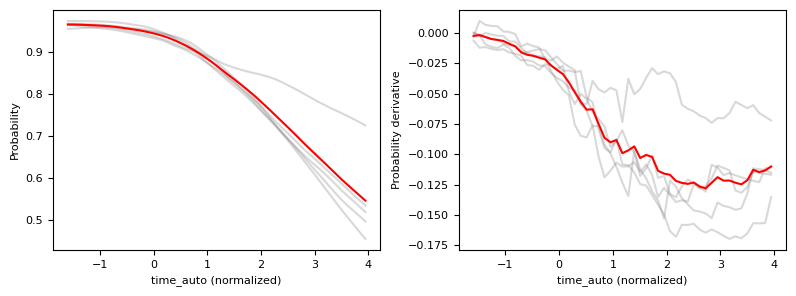

Penalty = 0.01
Model 1: test_loss = 0.6880, test_accuracy = 76.0%
Model 2: test_loss = 0.6817, test_accuracy = 75.0%
Model 3: test_loss = 0.6979, test_accuracy = 74.0%
Model 4: test_loss = 0.6841, test_accuracy = 74.0%
Model 5: test_loss = 0.7054, test_accuracy = 75.5%
Mean loss = 0.6914
Mean accuracy = 74.9%


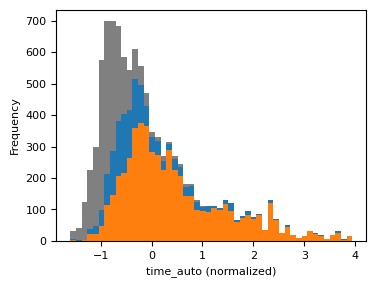

Strong regularity = 0.5465
Weak regularity = 0.7102


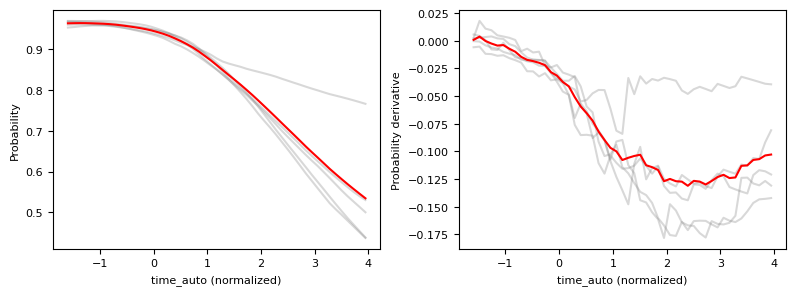

Penalty = 0.001
Model 1: test_loss = 0.6874, test_accuracy = 76.0%
Model 2: test_loss = 0.6820, test_accuracy = 76.0%
Model 3: test_loss = 0.6986, test_accuracy = 74.0%
Model 4: test_loss = 0.6855, test_accuracy = 74.0%
Model 5: test_loss = 0.7048, test_accuracy = 76.0%
Mean loss = 0.6917
Mean accuracy = 75.2%


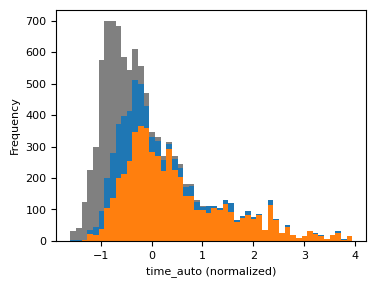

Strong regularity = 0.5374
Weak regularity = 0.7050


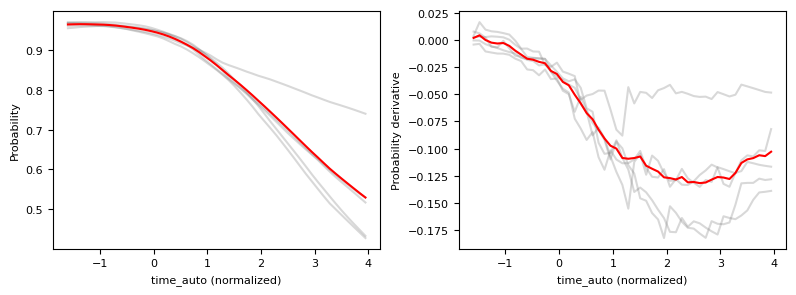

Penalty = 0.0001
Model 1: test_loss = 0.6864, test_accuracy = 76.0%
Model 2: test_loss = 0.6805, test_accuracy = 75.0%
Model 3: test_loss = 0.6962, test_accuracy = 74.0%
Model 4: test_loss = 0.6830, test_accuracy = 74.0%
Model 5: test_loss = 0.7056, test_accuracy = 76.0%
Mean loss = 0.6903
Mean accuracy = 75.0%


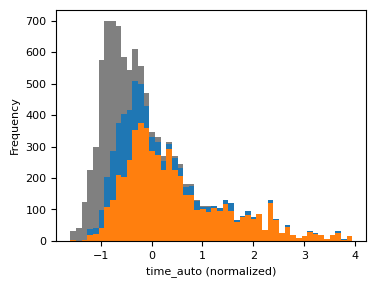

Strong regularity = 0.5415
Weak regularity = 0.7064


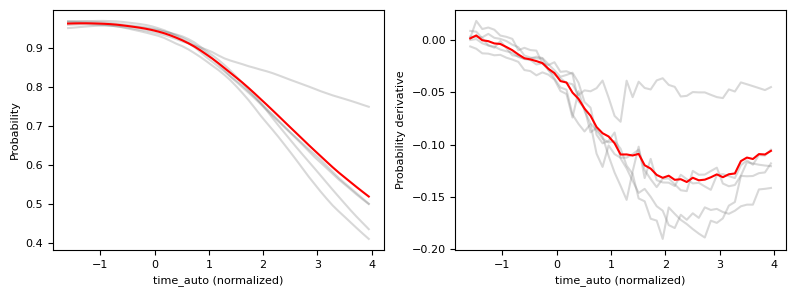

Model comparison:


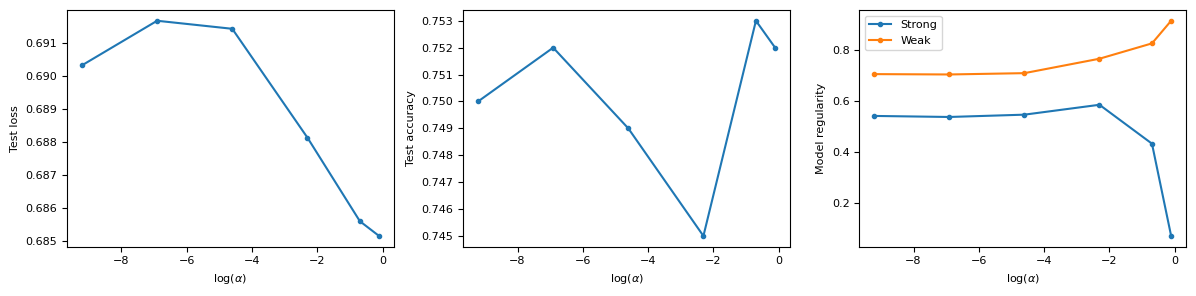

In [ ]:
# With norm
result('loss', [.9, .5, .1, 1e-2, 1e-3, 1e-4], [0, 0, 1])